# Week 2 - Counting Words & Phrases

This week, we take text corpora that we have developed, spidered, scraped, and encoded, and we find and count words, simple and parsed phrases and explore the statistical properties of those counts (e.g., word frequency distributions). Initially, we model how to search corpora for keywords or phrases. Next, we examine the distributions of terms and phrases across a corpus, and the correlation between different words and phrase counts. In order to do this effectively, we coarsely disambiguate words based of part-of-speech (POS) tagging, and normalize them through stemming and lemmatization. Next we distinguish *important* words and phrase within the corpus, and image them with Wordls! Then we calculate word frequenceis, conditional frequences (the frequency of word *shock* conditional on the presence of word *awe*), and statistically significant collocations of lengths 2 through $n$. Finally, we calculate and visualize Differences (Divergences and Distances) between the word frequency distributions from two corpora. 

Then we shift to focus not simply on the *ideas* in a corpus, but also extracting precise *claims*. This process involves a sequential pipeline of classifying and structuring tokens from text, each of which generates potentially useful data for the content analyst. Steps in this process, which we examine in this notebook, include: 1) tagging words by their part of speech (POS) to reveal the linguistic role they play in the sentence (e.g., Verb, Noun, Adjective, etc.); 2) tagging words as named entities (NER) such as places or organizations; 3) structuring or "parsing" sentences into nested phrases that are local to, describe or depend on one another; and 4) extracting informational claims from those phrases.

We will be introducing spaCy as a package for Computational Linguistics, and also walk you through how to use the Davies Corpora. 

While we wish to avoid using NLTK for heavy corpus analysis, some of its smaller functions can still be useful.

Of course, for final projects that draw on these tools, we encourage you to install the software on your own machines or shared servers at the university (RCC, SSRC) in order to perform these operations on much more text. 

For this notebook we will be using the following packages:


In [5]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
import lucem_illud #just in case, regularly update your lucem_illud with the following code: pip install git+git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git

#All these packages need to be installed from pip
import requests #for http requests
import pandas #gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import wordcloud #Makes word clouds
import numpy as np #For divergences/distances
import scipy #For divergences/distances
import seaborn as sns #makes our plots look nicer
import sklearn.manifold #For a manifold plot
import json #For API responses
import urllib.parse #For joining urls

# comp-linguistics
import spacy

#Displays the graphs
import graphviz #You also need to install the command line graphviz

#These are from the standard library
import os.path
import zipfile
import subprocess
import io
import tempfile

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook
%matplotlib inline

# Retrieving exemplary corpora

To get started we will need some examples. Let's start by downloading one of the corpuses from the Davies set purchased for this class and developed by a computational linguist at Brigham Young University. We can get a list of works available from the [corpora here](https://www.english-corpora.org/).

In this notebook, I will be accessing the data locally - you also have access to this data through the Dropbox download link. The same code can be modified slighlty to access the rest of the corpora on RCC. 
There is a notebook describing this process in the same repository, as well as in the same directory on RCC.

In [10]:
corpus_name = "/Users/egemenpamukcu/Desktop/course-materials/content-analysis/corpora/Movies" 
# corpus_name = "Movies"

Just to be clear, your corpus_name should be different since you're not bhargav. Modify the corpus_name with your directory. This method extracts the text from the zip files and stroes the raw data.

In [11]:
def loadcorpus(corpus_name, corpus_style="text"):
    texts_raw = {}
    for file in os.listdir(corpus_name + "/"):
        if corpus_style in file:
            print(file)
            zfile = zipfile.ZipFile(corpus_name + "/" + file)
            for file in zfile.namelist():
                texts_raw[file] = []
                with zfile.open(file) as f:
                    for line in f:
                        texts_raw[file].append(line)
    return texts_raw

In [12]:
movie_raw = loadcorpus(corpus_name)

text_13_idi.zip
text_16_qll.zip
text_32_ldf.zip
text_19_gvc.zip
text_05_nko.zip
text_17_arp.zip
text_01_ote.zip
text_28_rfy.zip
text_31_akv.zip
text_22_etp.zip
text_11_uoy.zip
text_09_oii.zip
text_06_jfy.zip
text_14_lnc.zip
text_08_loh.zip
text_33_kje.zip
text_30_wkp.zip
text_07_oma.zip
text_03_mnq.zip
text_21_fqa.zip
text_29_oye.zip
text_27_fle.zip
text_23_fmh.zip
text_12_rcq.zip
text_00_myn.zip
text_10_aoy.zip
text_04_mlq.zip
text_20_cde.zip
text_02_mqu.zip
text_26_ngj.zip
text_24_ywo.zip
text_18_jfj.zip
text_25_byg.zip
text_15_guo.zip


In [13]:
movie_raw['11.txt'][0:3]

[b'\r\n',
 b'@@216680 Hey , I \'m talking to you Give me 600 dollars You wish ! That \'s all we \'ve left And you still go to gamble Shut up I earn the money Even that you ca n\'t take it for gamble Shut up What \'re you doing ? Bastard , I \'m gon na beat you You gambling pig , I \'ll beat the shit out of you You bitch I \'ll beat you You dare to hit me with something ! I \'ll kill you All you know is gambling I \'ll beat you What \'re you doing ? Let go of me Stop You \'ll kill Mom Mom , are you all right ? Do n\'t touch my money Dad , where \'re you going ? Go away Dad , do n\'t go Get lost Dad , come back You take Marble with you The way she \'s now Do you want to give me trouble ? I \'m in more trouble than you I am a woman I \'m a sailor You take care of Marble Just gamble a bit less is enough to raise the kid No way Raising her would be like raising others @ @ @ @ @ @ @ @ @ @ take care of her Marry her when she grows up And you tell her to be smart Do n\'t marry a gambler Hey , 

It seems messy, but nothing we can't clean. This basic method replaces some of the issues with the formatting, and prints the errors if any for debugging. Let us clean one of the raw text files.

We ignore the non-unicode data for convenience in our first pass.

In [14]:
def clean_raw_text(raw_texts):
    clean_texts = []
    for text in raw_texts:
        try:
            text = text.decode("utf-8")
            clean_text = text.replace(" \'m", "'m").replace(" \'ll", "'ll").replace(" \'re", "'re").replace(" \'s", "'s").replace(" \'re", "'re").replace(" n\'t", "n't").replace(" \'ve", "'ve").replace(" /'d", "'d")
            clean_texts.append(clean_text)
        except AttributeError:
            # print("ERROR CLEANING")
            # print(text)
            continue
        except UnicodeDecodeError:
            # print("Unicode Error, Skip")
            continue
    return clean_texts

In [15]:
clean_11 = clean_raw_text(movie_raw['11.txt'])

In [16]:
clean_11[1]

'@@216680 Hey , I\'m talking to you Give me 600 dollars You wish ! That\'s all we\'ve left And you still go to gamble Shut up I earn the money Even that you can\'t take it for gamble Shut up What\'re you doing ? Bastard , I\'m gon na beat you You gambling pig , I\'ll beat the shit out of you You bitch I\'ll beat you You dare to hit me with something ! I\'ll kill you All you know is gambling I\'ll beat you What\'re you doing ? Let go of me Stop You\'ll kill Mom Mom , are you all right ? Don\'t touch my money Dad , where\'re you going ? Go away Dad , don\'t go Get lost Dad , come back You take Marble with you The way she\'s now Do you want to give me trouble ? I\'m in more trouble than you I am a woman I\'m a sailor You take care of Marble Just gamble a bit less is enough to raise the kid No way Raising her would be like raising others @ @ @ @ @ @ @ @ @ @ take care of her Marry her when she grows up And you tell her to be smart Don\'t marry a gambler Hey , you want a quarrel ? No , never

This method cleaned a few basic formatting errors. You are welcome to experiment and add your own code to expand on cleaning the text. Once it begins to look the way you want it to, we can start using spaCy to do some heavier cleaning. spaCy does this through the use of language models. Make sure you have the spaCy english language model loaded. 

In [17]:
nlp = spacy.load("en")

This model is going to be the basis of most of the tasks which NLTK (the Natural Language Tool Kit) might have done otherwise. While NLTK uses a bunch of clunky models from multiple places, spacy neatly packs all functionality in one model. This deep trained model will start by doing our word tokenizing and normalising. These methods are already included in lucem illud, and here we will just demonstrate them outside the package so to explain what goes on under the hood.

When we run text through a spacy model, it performs a lot of computation on each of the tokens. Each token is given certain attributes, such as a part of speech, information whether it is a number, a stop word, and so on. 

To perform a tokenization, we check if the string includes punctuation and add this token. 

In [18]:
def word_tokenize(word_list):
    tokenized = []
    # pass word list through language model.
    doc = nlp(word_list)
    for token in doc:
        if not token.is_punct and len(token.text.strip()) > 0:
            tokenized.append(token.text)
    return tokenized

In [19]:
word_tokenize(clean_11[1])

['@@216680',
 'Hey',
 'I',
 "'m",
 'talking',
 'to',
 'you',
 'Give',
 'me',
 '600',
 'dollars',
 'You',
 'wish',
 'That',
 "'s",
 'all',
 'we',
 "'ve",
 'left',
 'And',
 'you',
 'still',
 'go',
 'to',
 'gamble',
 'Shut',
 'up',
 'I',
 'earn',
 'the',
 'money',
 'Even',
 'that',
 'you',
 'ca',
 "n't",
 'take',
 'it',
 'for',
 'gamble',
 'Shut',
 'up',
 'What',
 "'re",
 'you',
 'doing',
 'Bastard',
 'I',
 "'m",
 'gon',
 'na',
 'beat',
 'you',
 'You',
 'gambling',
 'pig',
 'I',
 "'ll",
 'beat',
 'the',
 'shit',
 'out',
 'of',
 'you',
 'You',
 'bitch',
 'I',
 "'ll",
 'beat',
 'you',
 'You',
 'dare',
 'to',
 'hit',
 'me',
 'with',
 'something',
 'I',
 "'ll",
 'kill',
 'you',
 'All',
 'you',
 'know',
 'is',
 'gambling',
 'I',
 "'ll",
 'beat',
 'you',
 'What',
 "'re",
 'you',
 'doing',
 'Let',
 'go',
 'of',
 'me',
 'Stop',
 'You',
 "'ll",
 'kill',
 'Mom',
 'Mom',
 'are',
 'you',
 'all',
 'right',
 'Do',
 "n't",
 'touch',
 'my',
 'money',
 'Dad',
 'where',
 "'re",
 'you',
 'going',
 'Go',
 'a

You can see how the sentence is broken into its constituent words. We can then do some analysis with this. 

Note: we still don't know which movie this is, just that it is raw movie text data. Maybe in the process of our text cleaning and counting we will come across something!

# Counting words

If we want to do some analysis we can start by simply counting the number of times each word occurs within the corpus.

In [21]:
def wordCounter(wordLst):
    wordCounts = {}
    for word in wordLst:
        #We usually need to normalize the case
        wLower = word.lower()
        if wLower in wordCounts:
            wordCounts[wLower] += 1
        else:
            wordCounts[wLower] = 1
    #convert to DataFrame
    countsForFrame = {'word' : [], 'count' : []}
    for w, c in wordCounts.items():
        countsForFrame['word'].append(w)
        countsForFrame['count'].append(c)
    return pandas.DataFrame(countsForFrame)

In [22]:
countedWords = wordCounter(word_tokenize(clean_11[1]))
countedWords[:10]

,word,count
0,@@216680,1
1,hey,16
2,i,191
3,'m,24
4,talking,2
5,to,112
6,you,302
7,give,14
8,me,82
9,600,1


Lets sort and plot our counts to investigate the shape of our word frequency distribution.

First we need to sort the words by count.

In [23]:
#Doing this in place (changing the original DataFrame) as we don't need the unsorted DataFrame
countedWords.sort_values('count', ascending=False, inplace=True)
countedWords[:100]

,word,count
6,you,302
2,i,191
13,'s,126
5,to,112
31,it,109
...,...,...
248,postman,10
187,please,9
328,but,9
215,as,9


Punctuation and very common words (articles 'a' and 'the'; prepositions 'of' and 'to') make up the most common values, but this isn't very interesting and can actually get in the way of our analysis. We may remove these 'function words' by removing according to a stopword list, setting some frequency threshold, or using a weighting scheme (like tf.idf) to decrease their influence - we will look at these methods in more detail as we go through this tutorial. 

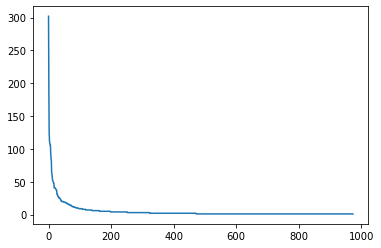

In [24]:
#Creating a figure and axis lets us do things like change the scaling or add a title
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(range(len(countedWords)), countedWords['count'])
plt.show()

This shows that likelihood of a word occurring is inversely proportional to its rank. This effect is called [Zipf's Law](https://en.wikipedia.org/wiki/Zipf%27s_law), and suggests that the most frequent word will occur approximately twice as often as the second most frequent word, three times as often as the third most frequent word, etc. Zipf's law is most easily observed by plotting the data on a log-log graph, with the axes being log (rank order) and log (frequency) resulting in a linear relationship.

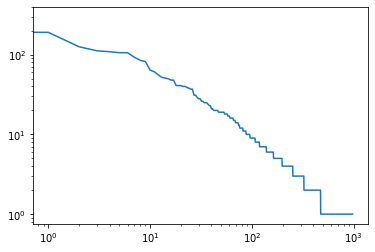

In [25]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(range(len(countedWords)), countedWords['count'])
ax.set_yscale('log')
ax.set_xscale('log')
plt.show()

(The same relationship occurs in many other rankings, such as population ranks of cities, corporation sizes, income rankings, etc.) 

The distribution was imagined by Zipf to be driven by a principle of 'least effort' where speakers did not work any harder than necessary to communicate a given idea, but the basis for this relationship is still not well understood and conforms at least as well to a process of [preferential attachment](https://en.wikipedia.org/wiki/Preferential_attachment) whereby people disproportionately attend to popular words.


# Getting and working with raw text

First, we will retrieve a collection of press releases from a *GitHub API* that archived them, based on a number of analyses by Justin Grimmer, a political scientist whose work we will read in two weeks!

GitHub API requests are made to `'https://api.github.com/'` and responses are in JSON, similar to Tumblr's API.

We will get the information on [github.com/lintool/GrimmerSenatePressReleases](https://github.com/lintool/GrimmerSenatePressReleases) as it contains a nice set documents.

In [26]:
r = requests.get('https://api.github.com/repos/lintool/GrimmerSenatePressReleases')
senateReleasesData = json.loads(r.text)
print(senateReleasesData.keys())
print(senateReleasesData['description'])

dict_keys(['id', 'node_id', 'name', 'full_name', 'private', 'owner', 'html_url', 'description', 'fork', 'url', 'forks_url', 'keys_url', 'collaborators_url', 'teams_url', 'hooks_url', 'issue_events_url', 'events_url', 'assignees_url', 'branches_url', 'tags_url', 'blobs_url', 'git_tags_url', 'git_refs_url', 'trees_url', 'statuses_url', 'languages_url', 'stargazers_url', 'contributors_url', 'subscribers_url', 'subscription_url', 'commits_url', 'git_commits_url', 'comments_url', 'issue_comment_url', 'contents_url', 'compare_url', 'merges_url', 'archive_url', 'downloads_url', 'issues_url', 'pulls_url', 'milestones_url', 'notifications_url', 'labels_url', 'releases_url', 'deployments_url', 'created_at', 'updated_at', 'pushed_at', 'git_url', 'ssh_url', 'clone_url', 'svn_url', 'homepage', 'size', 'stargazers_count', 'watchers_count', 'language', 'has_issues', 'has_projects', 'has_downloads', 'has_wiki', 'has_pages', 'forks_count', 'mirror_url', 'archived', 'disabled', 'open_issues_count', 'lic

What we are interested in here is the `'contents_url'`

In [27]:
print(senateReleasesData['contents_url'])

https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/{+path}


We can use this to get any or all of the files from the repo.

In [28]:
r = requests.get('https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Whitehouse')
whitehouseLinks = json.loads(r.text)
whitehouseLinks[0]

{'name': '10Apr2007Whitehouse123.txt',
 'path': 'raw/Whitehouse/10Apr2007Whitehouse123.txt',
 'sha': 'f524289ee563dca58690c8d36c23dce5dbd9962a',
 'size': 2206,
 'url': 'https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Whitehouse/10Apr2007Whitehouse123.txt?ref=master',
 'html_url': 'https://github.com/lintool/GrimmerSenatePressReleases/blob/master/raw/Whitehouse/10Apr2007Whitehouse123.txt',
 'git_url': 'https://api.github.com/repos/lintool/GrimmerSenatePressReleases/git/blobs/f524289ee563dca58690c8d36c23dce5dbd9962a',
 'download_url': 'https://raw.githubusercontent.com/lintool/GrimmerSenatePressReleases/master/raw/Whitehouse/10Apr2007Whitehouse123.txt',
 'type': 'file',
 '_links': {'self': 'https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Whitehouse/10Apr2007Whitehouse123.txt?ref=master',
  'git': 'https://api.github.com/repos/lintool/GrimmerSenatePressReleases/git/blobs/f524289ee563dca58690c8d36c23dce5dbd9962a',
  'html': 'https:/

Now we have a list of information about Whitehouse press releases. Let's look at one of them.

In [29]:
r = requests.get(whitehouseLinks[0]['download_url'])
whitehouseRelease = r.text
print(whitehouseRelease[:1000])
len(whitehouseRelease)

SEN. WHITEHOUSE SHARES WESTERLY GIRL'S STORY IN PUSH FOR STEM CELL RESEARCH
  Sharing the story of Lila Barber, a 12 year old girl from Westerly, Sen. Sheldon Whitehouse (D-R.I.) on Tuesday, April 10, 2007, illustrated the hope stem cell research can offer in a speech on the Senate floor in favor of legislation to expand federal funding for stem cell research.  
   Whitehouse met Lila two weeks ago. She was diagnosed two years ago with osteosarcoma, a cancerous bone condition, and last year underwent cadaver bone transplant surgery. The procedure saved her leg and is helping her remain cancer-free, but the transplanted tissue will not grow with her and likely will break down over time. Stem cell research, Whitehouse explained, could vastly improve the care of patients like Lila by allowing surgeons to enhance transplants with a patient's own stem cells, which could replace the lost bone and cartilage, or grow entirely new replacement bones and joints. 
   "Stem cell research gives hope

2206

Now we have a string of correctly encoded text. For analysis of its words, next we need to tokenize it, or split it into a sequence of tokens or word instances.

In [30]:
whTokens = word_tokenize(whitehouseRelease)
whTokens[10:30]

['STEM',
 'CELL',
 'RESEARCH',
 'Sharing',
 'the',
 'story',
 'of',
 'Lila',
 'Barber',
 'a',
 '12',
 'year',
 'old',
 'girl',
 'from',
 'Westerly',
 'Sen.',
 'Sheldon',
 'Whitehouse',
 'D']

Previous iterations of the course used `nltk`s tokenizer, but as we saw before, we used spaCy's model (https://spacy.io/api/tokenizer). We intend to avoid using NLTK when we can - for production level code, it is a lot faster and cleaner to use spaCy.

That being said, `nltk` does have some useful methods for quick analysis of small corpora. We will explore a few here, and encourage you to figure out for yourself which other ones might be useful.

To use the list of tokens in `nltk`, and take advantage of functions like `concordance`, shown above, we can convert it into a `Text`.

In [31]:
import nltk

In [33]:
whTokens

['SEN',
 'WHITEHOUSE',
 'SHARES',
 'WESTERLY',
 'GIRL',
 "'S",
 'STORY',
 'IN',
 'PUSH',
 'FOR',
 'STEM',
 'CELL',
 'RESEARCH',
 'Sharing',
 'the',
 'story',
 'of',
 'Lila',
 'Barber',
 'a',
 '12',
 'year',
 'old',
 'girl',
 'from',
 'Westerly',
 'Sen.',
 'Sheldon',
 'Whitehouse',
 'D',
 'R.I.',
 'on',
 'Tuesday',
 'April',
 '10',
 '2007',
 'illustrated',
 'the',
 'hope',
 'stem',
 'cell',
 'research',
 'can',
 'offer',
 'in',
 'a',
 'speech',
 'on',
 'the',
 'Senate',
 'floor',
 'in',
 'favor',
 'of',
 'legislation',
 'to',
 'expand',
 'federal',
 'funding',
 'for',
 'stem',
 'cell',
 'research',
 'Whitehouse',
 'met',
 'Lila',
 'two',
 'weeks',
 'ago',
 'She',
 'was',
 'diagnosed',
 'two',
 'years',
 'ago',
 'with',
 'osteosarcoma',
 'a',
 'cancerous',
 'bone',
 'condition',
 'and',
 'last',
 'year',
 'underwent',
 'cadaver',
 'bone',
 'transplant',
 'surgery',
 'The',
 'procedure',
 'saved',
 'her',
 'leg',
 'and',
 'is',
 'helping',
 'her',
 'remain',
 'cancer',
 'free',
 'but',
 '

In [34]:
whText = nltk.Text(whTokens)

whitehouseIndex = nltk.text.ConcordanceIndex(whText) 
whitehouseIndex.print_concordance('Whitehouse')

Displaying 5 of 5 matches:
ld girl from Westerly Sen. Sheldon Whitehouse D R.I. on Tuesday April 10 2007 il
ral funding for stem cell research Whitehouse met Lila two weeks ago She was dia
 down over time Stem cell research Whitehouse explained could vastly improve the
s research might help or even cure Whitehouse said Whitehouse also praised the e
 help or even cure Whitehouse said Whitehouse also praised the efforts of Rhode 


*Note* that the `Text` class is for doing rapid, exploratory analysis. It provides an easy interface to many of the operations we want to do, but it does not allow us much control over the particular operations it glosses. When you are doing a more complete analysis, you should be using the module specifically designed for that task instead of the shortcut method `Text` provides, e.g. use  [`collocations` Module](http://www.nltk.org/api/nltk.html#module-nltk.collocations) instead of `.collocations()`.

Now that we have gotten this loaded, let's glance at few features we will delve into more deeply later.

For example, we can find words that statistically tend to occur together and typically have a composite, idiomatic meaning irreducible to the semantics of its component words. We will do this later with more control over exactly how these are identified.

Or we can pick a word (or words) and find what words tend to occur around it.

In [35]:
whText.common_contexts(['stem'])

for_cell on_cells the_cell hope_cell time_cell own_cells joints_cell
of_cell embryonic_cells


We can also just count the number of times the word occurs.

In [36]:
whText.count('cell')

5


We can also plot each time a set of words occurs.

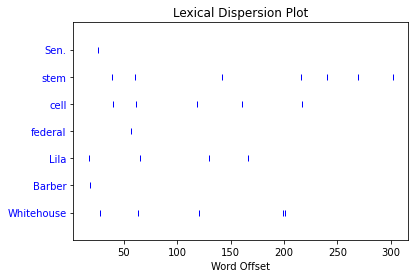

In [37]:
sns.reset_orig() #Seaborn messes with this plot, disabling it
whText.dispersion_plot(['Sen.','stem', 'cell', 'federal' ,'Lila', 'Barber', 'Whitehouse'])
sns.set() #Re-enabling seaborn

If we want to do an analysis of all the Whitehouse press releases we will first need to obtain them. By looking at the API we can see the the URL we want is [https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Whitehouse](https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Whitehouse), so we can create a function to scrape the individual files.

If you want to know more about downloading from APIs, refer back to the 1st notebook.

In [53]:
def getGithubFiles(target, maxFiles = 100):
    #We are setting a max so our examples don't take too long to run
    #For converting to a DataFrame
    releasesDict = {
        'name' : [], #The name of the file
        'text' : [], #The text of the file, watch out for binary files
        'path' : [], #The path in the git repo to the file
        'html_url' : [], #The url to see the file on Github
        'download_url' : [], #The url to download the file
    }

    #Get the directory information from Github
    r = requests.get(target)
    filesLst = json.loads(r.text)

    for fileDict in filesLst[:maxFiles]:
        #These are provided by the directory
        releasesDict['name'].append(fileDict['name'])
        releasesDict['path'].append(fileDict['path'])
        releasesDict['html_url'].append(fileDict['html_url'])
        releasesDict['download_url'].append(fileDict['download_url'])

        #We need to download the text though
        text = requests.get(fileDict['download_url']).text
        releasesDict['text'].append(text)

    return pandas.DataFrame(releasesDict)

whReleases = getGithubFiles('https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Whitehouse', maxFiles = 10)
whReleases[:5]

,name,text,path,html_url,download_url
0,10Apr2007Whitehouse123.txt,SEN. WHITEHOUSE SHARES WESTERLY GIRL'S STORY I...,raw/Whitehouse/10Apr2007Whitehouse123.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...
1,10Apr2008Whitehouse2.txt,SEN. WHITEHOUSE SAYS PRESIDENT BUSH MUST BEGIN...,raw/Whitehouse/10Apr2008Whitehouse2.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...
2,10Apr2008Whitehouse3.txt,EPA MUST REVIEW LEGAL PROCESS TO ROOT OUT POLI...,raw/Whitehouse/10Apr2008Whitehouse3.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...
3,10Aug2007Whitehouse78.txt,R.I. SENATORS PRAISE SEN. DENIAL OF LNG FACILI...,raw/Whitehouse/10Aug2007Whitehouse78.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...
4,10Jan2008Whitehouse35.txt,SEN. WHITEHOUSE COMMENTS ON ONE-YEAR ANNIVERSA...,raw/Whitehouse/10Jan2008Whitehouse35.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...


If you are having trouble downloading the data uncomment this next cell

In [54]:
#whReleases = pandas.read_csv('../data/whReleases.csv')

Now we have all the texts in a DataFrame we can look at a few things.

First let's tokenize the texts with the same tokenizer as we used before. We will just save the tokens as a list for now; no need to convert to `Text`s.

In [55]:
whReleases['tokenized_text'] = whReleases['text'].apply(lambda x: word_tokenize(x))

Now lets see how long each of the press releases is:

In [56]:
whReleases['word_counts'] = whReleases['tokenized_text'].apply(lambda x: len(x))
whReleases['word_counts']

0    350
1    311
2    497
3    189
4    236
5    334
6    241
7    469
8    443
9    425
Name: word_counts, dtype: int64

## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Construct cells immediately below this that input and interrogate a corpus relating to your anticipated final project. This could include one of the Davies corpora or some other you have constructed. Turn your text into an nltk `Text` object, and explore all of the features examined above, and others that relate to better understanding your corpus in relation to your research question. </span>

In [40]:
#load corpus subset
corpus_df = pandas.read_csv('speech_corpus.csv')

In [41]:
tokens = []
for i in corpus_df['Speech Content']:
    tokens += lucem_illud.word_tokenize(i)
len(tokens) #small subset

7877

In [42]:
def wordCounter(wordLst):
    wordCounts = {}
    for word in wordLst:
        #We usually need to normalize the case
        wLower = word.lower()
        if wLower in wordCounts:
            wordCounts[wLower] += 1
        else:
            wordCounts[wLower] = 1
    #convert to DataFrame
    countsForFrame = {'word' : [], 'count' : []}
    for w, c in wordCounts.items():
        countsForFrame['word'].append(w)
        countsForFrame['count'].append(c)
    return pandas.DataFrame(countsForFrame)

In [43]:
count_df = wordCounter(tokens).sort_values('count', ascending=False)
count_df

,word,count
28,the,413
27,to,340
6,and,330
52,of,182
16,we,145
...,...,...
927,vision,1
928,competence,1
929,largest,1
932,nomination,1


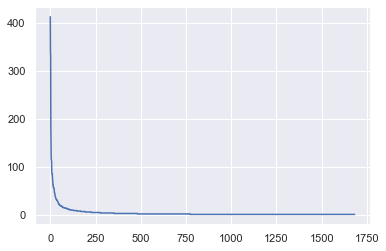

In [44]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(range(len(count_df)), count_df['count'])
plt.show()

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(range(len(count_df)), count_df['count'])
ax.set_yscale('log')
ax.set_xscale('log')
plt.show()

In [46]:
speech_text = nltk.Text(tokens)
speech_text[:10]

['Good',
 'afternoon',
 'folks',
 'Vice',
 'President',
 'Harris',
 'and',
 'I',
 'just',
 'received']

In [47]:
speech_index = nltk.text.ConcordanceIndex(speech_text)

In [48]:
speech_index.print_concordance('president')

Displaying 6 of 6 matches:
 duty to advise and consent on the president ’s appointments to his cabinet Thi
e a vote on whether to convict the president I ’ve spoken to Speaker Pelosi who
t makes no sense whatsoever that a president or any official could commit a hei
lebrated the inauguration of a new president and the turning over of a new leaf
nd honor that could be expected As president as Commander In Chief I always res
 from Dr. Fauci again Not from the president but from the real genuine experts 


In [49]:
speech_text.common_contexts(['jobs'])

their_and in_and million_just 18,600,000_that their_over their_in
maintain_plus two_and more_good paying_not wage_it losing_i


In [50]:
speech_text.count('COVID-19')

19

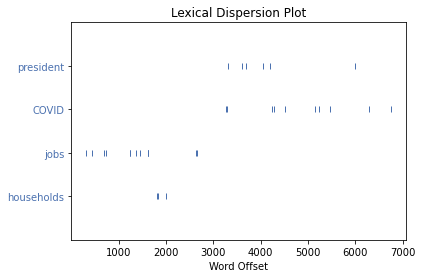

In [51]:
sns.reset_orig() #Seaborn messes with this plot, disabling it
speech_text.dispersion_plot(['president','COVID', 'jobs', 'households'])
sns.set() #Re-enabling seaborn

# Filtering and normalizing text

As we want to start comparing the different releases we may choose to do a bit of filtering and normalizing that will allow us to focus on what we most care about. We can first make all of the words lower case, then drop the non-word tokens. Next, we can remove some 'stop words', stem the remaining words to remove suffixes, prefixes and (in some languages) infixes, or lemmatize tokens by intelligently grouping inflected or variant forms of the same word (e.g., with a stemmer and a dictionary). 

To begin this process, we will first define a function to work over the tokenized lists, then another to add normalized tokens to a new column.

We will be using spaCy's built in stop words identifying capacity. When we run text through spaCy's language pipeline, it automatically tags it as a stop word. 

We can remove these stopwords from the analysis by fiat, but we could also take a more principled approach by looking at the frequency distribution of words and selecting a specific cut-off associated with the preservation of 'meaningful words' identified upon inspection. Alternatively, we could automatically set a cut-off by rule, such as removal of all words more frequent then the most frequent verb, or the most frequent noun (not pronoun), or some term of central interest. 

In [57]:
countsDict = {}
for word in whReleases['tokenized_text'].sum():
    if word in countsDict:
        countsDict[word] += 1
    else:
        countsDict[word] = 1
word_counts = sorted(countsDict.items(), key = lambda x : x[1], reverse = True)
word_counts[:20]

[('the', 179),
 ('of', 112),
 ('to', 112),
 ('and', 108),
 ('in', 64),
 ('a', 61),
 ("'s", 50),
 ('that', 41),
 ('our', 39),
 ('for', 35),
 ('on', 33),
 ('is', 33),
 ('Whitehouse', 31),
 ('Iraq', 28),
 ('Bush', 27),
 ('President', 25),
 ('troops', 21),
 ('by', 19),
 ('American', 19),
 ('with', 18)]

We can look at this and pick the cutoff, often at the first noun. So we will cut all words before `'Whitehouse'`.

In [65]:
#The stop list is then all words that occur before the first noun
stop_words_freq = []
for word, count in word_counts:
    if word == 'Whitehouse':
        break
    else:
        stop_words_freq.append(word)
stop_words_freq

['the', 'of', 'to', 'and', 'in', 'a', "'s", 'that', 'our', 'for', 'on', 'is']

If we did have any extra words to add as stop words apart from those normally considered as stop words, we would add it to our stop words by passing it to the normalize tokens method. 

Now we can create our function to normalize the tokens

In [66]:
def normalizeTokens(word_list, extra_stop=[]):
    #We can use a generator here as we just need to iterate over it
    normalized = []
    if type(word_list) == list and len(word_list) == 1:
        word_list = word_list[0]

    if type(word_list) == list:
        word_list = ' '.join([str(elem) for elem in word_list]) 

    doc = nlp(word_list.lower())
    
    # add the property of stop word to words considered as stop words
    if len(extra_stop) > 0:
        for stopword in extra_stop:
            lexeme = nlp.vocab[stopword]
            lexeme.is_stop = True

    for w in doc:
        # if it's not a stop word or punctuation mark, add it to our article
        if w.text != '\n' and not w.is_stop and not w.is_punct and not w.like_num and len(w.text.strip()) > 0:
            # we add the lematized version of the word
            normalized.append(str(w.lemma_))

    return normalized

In [67]:
whReleases['normalized_tokens'] = whReleases['tokenized_text'].apply(lambda x: normalizeTokens(x))

whReleases['normalized_tokens_count'] = whReleases['normalized_tokens'].apply(lambda x: len(x))

whReleases

,name,text,path,html_url,download_url,tokenized_text,word_counts,normalized_tokens,normalized_tokens_count
0,10Apr2007Whitehouse123.txt,SEN. WHITEHOUSE SHARES WESTERLY GIRL'S STORY I...,raw/Whitehouse/10Apr2007Whitehouse123.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,"[SEN, WHITEHOUSE, SHARES, WESTERLY, GIRL, 'S, ...",350,"[sen, whitehouse, share, westerly, girl, story...",224
1,10Apr2008Whitehouse2.txt,SEN. WHITEHOUSE SAYS PRESIDENT BUSH MUST BEGIN...,raw/Whitehouse/10Apr2008Whitehouse2.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,"[SEN, WHITEHOUSE, SAYS, PRESIDENT, BUSH, MUST,...",311,"[sen, whitehouse, say, president, bush, begin,...",159
2,10Apr2008Whitehouse3.txt,EPA MUST REVIEW LEGAL PROCESS TO ROOT OUT POLI...,raw/Whitehouse/10Apr2008Whitehouse3.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,"[EPA, MUST, REVIEW, LEGAL, PROCESS, TO, ROOT, ...",497,"[epa, review, legal, process, root, political,...",298
3,10Aug2007Whitehouse78.txt,R.I. SENATORS PRAISE SEN. DENIAL OF LNG FACILI...,raw/Whitehouse/10Aug2007Whitehouse78.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,"[R.I., SENATORS, PRAISE, SEN, DENIAL, OF, LNG,...",189,"[r.i, senator, praise, sen, denial, lng, facil...",116
4,10Jan2008Whitehouse35.txt,SEN. WHITEHOUSE COMMENTS ON ONE-YEAR ANNIVERSA...,raw/Whitehouse/10Jan2008Whitehouse35.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,"[SEN, WHITEHOUSE, COMMENTS, ON, ONE, YEAR, ANN...",236,"[sen, whitehouse, comment, year, anniversary, ...",125
5,10Mar2008Whitehouse8.txt,"SENS. REED, WHITEHOUSE WELCOME RHODE ISLAND ST...",raw/Whitehouse/10Mar2008Whitehouse8.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,"[SENS, REED, WHITEHOUSE, WELCOME, RHODE, ISLAN...",334,"[sen, reed, whitehouse, welcome, rhode, island...",197
6,10Sep2007Whitehouse72.txt,REP. WHITEHOUSE ISSUES STATEMENT ON GEN. PETRA...,raw/Whitehouse/10Sep2007Whitehouse72.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,"[REP, WHITEHOUSE, ISSUES, STATEMENT, ON, GEN, ...",241,"[rep, whitehouse, issue, statement, gen, petra...",118
7,11Apr2007Whitehouse122.txt,SEN. WHITEHOUSE URGES BUSH FOR NEW DIRECTION I...,raw/Whitehouse/11Apr2007Whitehouse122.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,"[SEN, WHITEHOUSE, URGES, BUSH, FOR, NEW, DIREC...",469,"[sen, whitehouse, urge, bush, new, direction, ...",249
8,11Jan2007Whitehouse161.txt,"SENS. REED, WHITEHOUSE URGE PORTUGAL TO RECONS...",raw/Whitehouse/11Jan2007Whitehouse161.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,"[SENS, REED, WHITEHOUSE, URGE, PORTUGAL, TO, R...",443,"[sen, reed, whitehouse, urge, portugal, recons...",237
9,11Mar2008Whitehouse7.txt,WHITEHOUSE UNVEILS 'BUSH DEBT': $7.7 TRILLION ...,raw/Whitehouse/11Mar2008Whitehouse7.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,"[WHITEHOUSE, UNVEILS, BUSH, DEBT, $, 7.7, TRIL...",425,"[whitehouse, unveils, bush, debt, $, foregone,...",241


You can see that in the final step of normalizing, we add the lemmatized form of the word. spaCy's built in lemmatizer does this (https://spacy.io/api/lemmatizer). Lemmatization can be thought of as finding the root or the base of the word after removing inflections and other variations of words. Another possible way of finding the roots of words is using NLTK's porting or stemming functionalities, but we will not be getting into them.

Now that it is cleaned we start analyzing the dataset. We can start by finding frequency distributions for the dataset. Lets start looking at all the press releases together. The [`ConditionalFreqDist`](http://www.nltk.org/api/nltk.html#nltk.probability.ConditionalProbDist) class reads in an iterable of tuples, the first element is the condition and the second the focal word. For starters, we will use word lengths as the conditions, but tags or clusters will provide more useful results.

In [68]:
#.sum() adds together the lists from each row into a single list
whcfdist = nltk.ConditionalFreqDist(((len(w), w) for w in whReleases['normalized_tokens'].sum()))

#print the number of words
print(whcfdist.N())

1964


From this we can lookup the distributions of different word lengths

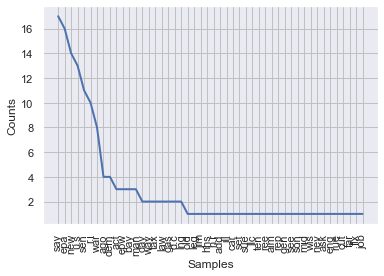

In [69]:
whcfdist[3].plot()

We can also create a Conditional Probability Distribution or [`ConditionalProbDist`](http://www.nltk.org/api/nltk.html#nltk.probability.ConditionalProbDist) from the `ConditionalFreqDist`. To do this, however, we need a model for the probability distribution. A simple model is [`ELEProbDist`](http://www.nltk.org/api/nltk.html#nltk.probability.ELEProbDist) which gives the expected likelihood estimate for the probability distribution of the experiment used to generate the observed frequency distribution. 

In [70]:
whcpdist = nltk.ConditionalProbDist(whcfdist, nltk.ELEProbDist)

#print the most common 2 letter word
print(whcpdist[2].max())

#And its probability
print(whcpdist[2].prob(whcpdist[2].max()))

ri
0.25


Length is one feature of a word, but there are many more important features we care about. Another critical feature is a word's role in the sentence, or its part of speech (POS). 

The method below works similarly to ```nltk.pos_text```, and can work with the conditional frequency distributions it provides.

In [72]:
def spacy_pos(word_list):
    tags = []
    doc = nlp(word_list.lower())
    for w in doc:
        tags.append((w.text, w.tag_))
    return tags

In [73]:
whReleases['normalized_tokens_POS'] = [spacy_pos(t) for t in whReleases['text']]

This gives us a new column with the part of speech as a short initialism and the word in a tuple, exactly how the `nltk.ConditionalFreqDist()` function wants them. We can now construct another conditional frequency distribution.

In [74]:
whcfdist_WordtoPOS = nltk.ConditionalFreqDist(whReleases['normalized_tokens_POS'].sum())
list(whcfdist_WordtoPOS.items())[:10]

[('sen', FreqDist({'NNP': 9})),
 ('.', FreqDist({'.': 125, 'NNP': 41})),
 ('whitehouse', FreqDist({'NN': 19, 'NNP': 12, 'VB': 8, 'VBP': 1})),
 ('shares', FreqDist({'NNS': 1})),
 ('westerly', FreqDist({'NNP': 2})),
 ('girl', FreqDist({'NN': 2})),
 ("'s", FreqDist({'POS': 47, 'VBZ': 5})),
 ('story', FreqDist({'NN': 2})),
 ('in', FreqDist({'IN': 72})),
 ('push', FreqDist({'NN': 1}))]

This gives the frequency of each word as each part of speech...which can be uninformative and boring. What we want is the converse; the frequency of each part of speech for each word.

In [75]:
whcfdist_POStoWord = nltk.ConditionalFreqDist((p, w) for w, p in whReleases['normalized_tokens_POS'].sum())

We can now identify and collect all of the superlative adjectives

In [76]:
whcfdist_POStoWord['JJ']

FreqDist({'american': 17, 'new': 10, 'portuguese': 9, 'political': 8, 'federal': 6, 'clear': 5, 'potential': 5, 'fiscal': 5, 'last': 4, 'several': 4, ...})

Or look at the most common nouns

In [77]:
whcfdist_POStoWord['NN'].most_common(5)

[('whitehouse', 19),
 ('today', 15),
 ('stem', 12),
 ('year', 12),
 ('administration', 11)]

Or plot the base form verbs against their number of occurrences

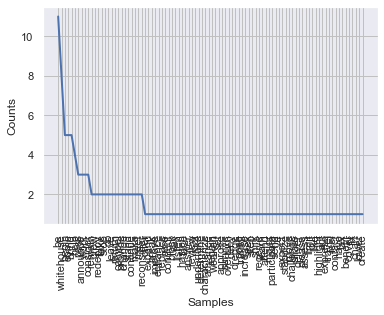

In [78]:
whcfdist_POStoWord['VB'].plot()

We can then do a similar analysis of the word probabilities

In [79]:
whcpdist_POStoWord = nltk.ConditionalProbDist(whcfdist_POStoWord, nltk.ELEProbDist)

#print the most common nouns
print(whcpdist_POStoWord['NN'].max())

#And its probability
print(whcpdist_POStoWord['NN'].prob(whcpdist_POStoWord['NN'].max()))

whitehouse
0.025390625


We can even create a...wait for it...*WORD CLOUD* or Wordl to gaze at and draw mystical, approximate inferences about important nouns and verbs in our corpus:

(-0.5, 499.5, 499.5, -0.5)

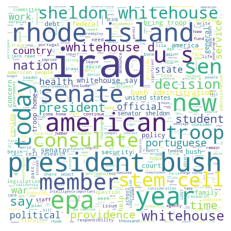

In [81]:
wc = wordcloud.WordCloud(background_color="white", max_words=500, width= 1000, height = 1000, mode ='RGBA', scale=.5).generate(' '.join(whReleases['normalized_tokens'].sum()))
plt.imshow(wc)
plt.axis("off")
#plt.savefig("whitehouse_word_cloud.pdf", format = 'pdf')

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">Construct cells immediately below this that filter, stem and lemmatize the tokens in your corpus, and then creates plots (with titles and labels) that map the word frequency distribution, word probability distribution, and at least two conditional probability distributions that help us better understand the social and cultural game underlying the production of your corpus. Create a wordl of words (or normalized words) and add a few vague comments about what mysteries are revealed through it.</span>

In [82]:
countsDict = {}
for word in tokens:
    countsDict[word] = countsDict.get(word, 0) + 1
word_counts = sorted(countsDict.items(), key = lambda x: x[1], reverse = True)
word_counts[:40]

[('the', 375),
 ('to', 335),
 ('and', 278),
 ('of', 178),
 ('a', 113),
 ('in', 104),
 ('that', 100),
 ('we', 99),
 ('I', 93),
 ('’s', 87),
 ('for', 72),
 ('will', 71),
 ('this', 64),
 ('is', 62),
 ('our', 61),
 ('on', 61),
 ('have', 56),
 ('be', 56),
 ('are', 55),
 ('you', 55),
 ('it', 53),
 ('And', 52),
 ('as', 50),
 ('We', 46),
 ('going', 45),
 ('’re', 45),
 ('they', 44),
 ('The', 38),
 ('with', 37),
 ('not', 36),
 ('their', 35),
 ('who', 33),
 ('people', 33),
 ('It', 32),
 ('all', 32),
 ('do', 32),
 ('health', 30),
 ('more', 30),
 ('plan', 30),
 ('get', 30)]

In [83]:
stop_words_freq = []
for word, count in word_counts:
    if word == 'health':
        break
    else:
        stop_words_freq.append(word)
stop_words_freq

['the',
 'to',
 'and',
 'of',
 'a',
 'in',
 'that',
 'we',
 'I',
 '’s',
 'for',
 'will',
 'this',
 'is',
 'our',
 'on',
 'have',
 'be',
 'are',
 'you',
 'it',
 'And',
 'as',
 'We',
 'going',
 '’re',
 'they',
 'The',
 'with',
 'not',
 'their',
 'who',
 'people',
 'It',
 'all',
 'do']

In [85]:
corpus_df['tokenized_text'] = corpus_df['Speech Content'].apply(lambda x: lucem_illud.word_tokenize(x))

In [86]:
def normalizeTokens(word_list, extra_stop=[]):
    #We can use a generator here as we just need to iterate over it
    normalized = []
    if type(word_list) == list and len(word_list) == 1:
        word_list = word_list[0]

    if type(word_list) == list:
        word_list = ' '.join([str(elem) for elem in word_list]) 

    doc = nlp(word_list.lower())
    
    # add the property of stop word to words considered as stop words
    if len(extra_stop) > 0:
        for stopword in extra_stop:
            lexeme = nlp.vocab[stopword]
            lexeme.is_stop = True

    for w in doc:
        # if it's not a stop word or punctuation mark, add it to our article
        if w.text != '\n' and not w.is_stop and not w.is_punct and not w.like_num and len(w.text.strip()) > 0:
            # we add the lematized version of the word
            normalized.append(str(w.lemma_))

    return normalized

In [87]:
corpus_df['normalized_tokens'] = corpus_df['tokenized_text'].apply(lambda x: normalizeTokens(x, stop_words_freq))
corpus_df['normalized_tokens_count'] = corpus_df['normalized_tokens'].apply(lambda x: len(x))

In [89]:
speech_cfd = nltk.ConditionalFreqDist(((len(w), w) for w in corpus_df['normalized_tokens'].sum()))
print(speech_cfd.N())

3413


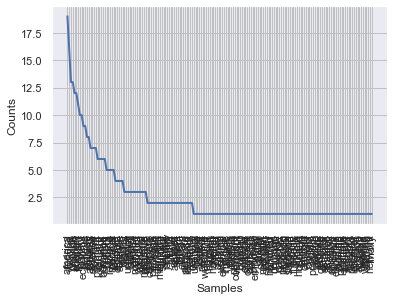

In [90]:
speech_cfd[7].plot();

In [91]:
speech_pd = nltk.ConditionalProbDist(speech_cfd, nltk.ELEProbDist)
print(speech_pd[15].max()) #brings the most common word based on length
print(speech_pd[15].prob(speech_pd[15].max())) #brings the probability of a word

competitiveness
0.3333333333333333


In [92]:
def spacy_pos(word_list):
    tags = []
    doc = nlp(word_list.lower())
    for w in doc:
        tags.append((w.text, w.tag_))
    return tags

In [93]:
corpus_df['normalized_tokens_POS'] = [spacy_pos(t) for t in corpus_df['Speech Content']]

In [94]:
speechcfd_POStoWord = nltk.ConditionalFreqDist(corpus_df['normalized_tokens_POS'].sum())
list(speechcfd_POStoWord.items())[:10]

[('good', FreqDist({'JJ': 4, 'NNP': 1})),
 ('afternoon', FreqDist({'NN': 1})),
 (',', FreqDist({',': 439})),
 ('folks', FreqDist({'NNS': 7})),
 ('.', FreqDist({'.': 450, 'NNP': 17})),
 ('vice', FreqDist({'NNP': 2, 'NN': 1})),
 ('president', FreqDist({'NNP': 19, 'NN': 5})),
 ('harris', FreqDist({'NNP': 4})),
 ('and', FreqDist({'CC': 330})),
 ('i', FreqDist({'PRP': 92, 'NNP': 1}))]

In [95]:
speechcfd_WordtoPOS = nltk.ConditionalFreqDist((p, w) for w, p in corpus_df['normalized_tokens_POS'].sum())

In [96]:
speechcfd_WordtoPOS['JJ']

FreqDist({'next': 18, 'american': 18, 'federal': 15, 'economic': 14, 'first': 14, 'last': 14, 'global': 13, 'national': 12, 'executive': 11, 'covid': 10, ...})

In [97]:
speechcfd_WordtoPOS['JJ'].most_common(10)

[('next', 18),
 ('american', 18),
 ('federal', 15),
 ('economic', 14),
 ('first', 14),
 ('last', 14),
 ('global', 13),
 ('national', 12),
 ('executive', 11),
 ('covid', 10)]

In [98]:
speechcfd_WordtoPOS['NN'].most_common(10)

[('plan', 41),
 ('health', 33),
 ('pandemic', 19),
 ('today', 18),
 ('world', 15),
 ('time', 14),
 ('trial', 12),
 ('yesterday', 11),
 ('leader', 11),
 ('crisis', 10)]

In [99]:
speechcfd_WordtoPOS['VB'].most_common(10)

[('be', 56),
 ('get', 26),
 ('do', 17),
 ('have', 13),
 ('let', 13),
 ('help', 13),
 ('act', 12),
 ('work', 12),
 ('make', 12),
 ('take', 12)]

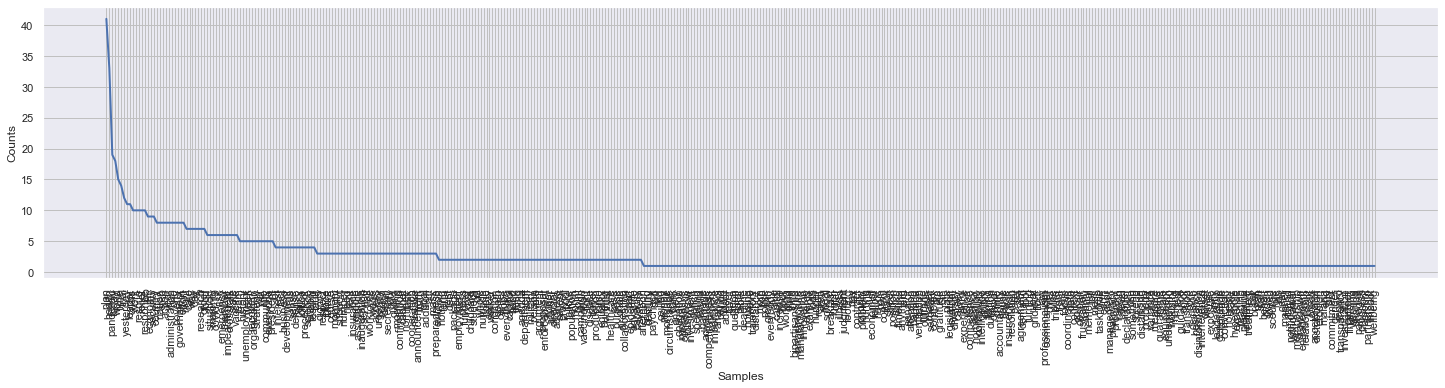

In [103]:
plt.figure(figsize=(25, 5))
speechcfd_WordtoPOS['NN'].plot()

In [104]:
speechpd_POStoWord = nltk.ConditionalProbDist(speechcfd_WordtoPOS, nltk.ELEProbDist)

In [105]:
print(speechpd_POStoWord['NN'].max())
print(speechpd_POStoWord['NN'].prob(speechpd_POStoWord['NN'].max()))

plan
0.0323208722741433


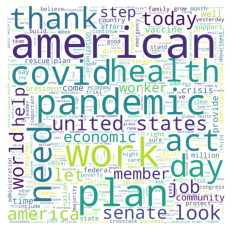

In [108]:
wc = wordcloud.WordCloud(background_color="white", max_words=500, width= 2000, height = 2000, mode ='RGBA', scale=1).generate(' '.join(corpus_df['normalized_tokens'].sum()))
plt.imshow(wc)
plt.axis("off")
plt.savefig("whitehouse_word_cloud.pdf", format = 'pdf')

As expected, there is a focus on the plans of economic recovery after the pandemic. 

## Davies Corpora

Now that we have our basic cleaning down, we can arrange our Davies Corpora. Let us try this with the movies corpora we have already loaded.

We'll use a smaller corpus of a 1000 movies for this demonstration.

In [109]:
zfile = zipfile.ZipFile(corpus_name + "/sources_movies.zip")
source = []

In [110]:
for file in zfile.namelist():
    with zfile.open(file) as f:
        for line in f:
            source.append(line)

In [111]:
source[0:20]

[b'textID\tfileID\t#words\tgenre\tyear\tlanguage(s)\tcountry\timdb\ttitle\r\n',
 b'-----\t-----\t-----\t-----\t-----\t-----\t-----\t-----\t-----\r\n',
 b'\r\n',
 b'290635\t3547424\t4722\tShort, Musical\t1930\tUK\tEnglish\t0290635\tGoodbye to All That\r\n',
 b'21165\t6332374\t10220\tCrime, Mystery, Thriller\t1930\tUK\tEnglish\t0021165\tMurder!\r\n',
 b'21191\t6013789\t5281\tDrama, Romance\t1930\tUSA\tEnglish\t0021191\tA Notorious Affair\r\n',
 b'20620\t3660608\t6724\tBiography, Drama, History\t1930\tUSA\tEnglish\t0020620\tAbraham Lincoln\r\n',
 b'20629\t60053\t9552\tDrama, War\t1930\tUSA\tEnglish, French, German, Latin\t0020629\tAll Quiet on the Western Front\r\n',
 b'20640\t6850720\t13862\tComedy, Musical\t1930\tUSA\tEnglish\t0020640\tAnimal Crackers\r\n',
 b'20641\t176501\t11140\tDrama, Romance\t1930\tUSA\tEnglish\t0020641\tAnna Christie\r\n',
 b'20643\t3603861\t1748\tComedy, Short\t1930\tUSA\tEnglish\t0020643\tAnother Fine Mess\r\n',
 b'20670\t4159455\t6966\tComedy, Musical\t1930\tUS

It looks dirty because the file is encoded as bytes, but we can certainly see the information there. The file id is also present in the original raw text data: as the first "word". Look back at the normalized/tokenized words to confirm that. We're going to use this to create a dataframe with: Fileid, movie name, genre, year, and country.

It is advised that you run a similar check of the source file before you do other extraction.

First, let us create a dictionary mapping file-id to all the text. Each movie will be mapped to a list of the tokenized words.

In this example, I only use it to load 100 movies. You can comment this out or increase/decrease the number as you see fit.

In [112]:
movie_texts = {}

In [114]:
for files in movie_raw:
    if len(movie_texts) > 100:
        break
    movies = clean_raw_text(movie_raw[files][1:])
    for movie in movies:
        txts = lucem_illud.word_tokenize(movie)
        try:
            movie_texts[txts[0][2:]] = txts[1:]
        except IndexError:
            continue

In [115]:
import pandas as pd

In [116]:
movie_df = pd.DataFrame(columns=["Movie Name", "Genre", "Year", "Country", "Tokenized Texts"])

In [117]:
for movie in source[3:]:
    try:
        tid, fileid, total_words, genre, year, lang, country, imdb, title = movie.decode("utf-8").split("\t")
    except UnicodeDecodeError:
        continue
    try:
        movie_df.loc[fileid.strip()] = [title.strip(), genre.strip(), year.strip(), country.strip(), movie_texts[fileid.strip()]]
    except KeyError:
        continue

In [118]:
movie_df.head()

,Movie Name,Genre,Year,Country,Tokenized Texts
6850720,Animal Crackers,"Comedy, Musical",1930,English,"[You, must, do, your, best, tonight, Be, on, y..."
176501,Anna Christie,"Drama, Romance",1930,English,"[Either, you, 're, flat, or, I, am, I, beg, yo..."
4056770,Ladies of Leisure,"Drama, Romance",1930,English,"[Look, out, There, 's, another, bottle, coming..."
5992934,Over the Hill,Drama,1931,English,"[Good, morning, kitty, Come, in, here, baby, I..."
4436137,Design for Living,"Comedy, Romance",1933,"English, French","[Train_engine_grinding, 26;1426;TOOLONG, Whist..."


# Part-of-Speech (POS) tagging

In POS tagging, we classify each word by its semantic role in a sentence. We will be using the in-built spaCy pos-tagging.

https://spacy.io/usage/linguistic-features

|#. |Tag |Description |
|---|----|------------|
|1.	|CC	|Coordinating conjunction
|2.	|CD	|Cardinal number
|3.	|DT	|Determiner
|4.	|EX	|Existential there
|5.	|FW	|Foreign word
|6.	|IN	|Preposition or subordinating conjunction
|7.	|JJ	|Adjective
|8.	|JJR|	Adjective, comparative
|9.	|JJS|	Adjective, superlative
|10.|	LS	|List item marker
|11.|	MD	|Modal
|12.|	NN	|Noun, singular or mass
|13.|	NNS	|Noun, plural
|14.|	NNP	|Proper noun, singular
|15.|	NNPS|	Proper noun, plural
|16.|	PDT	|Predeterminer
|17.|	POS	|Possessive ending
|18.|	PRP	|Personal pronoun
|19.|	PRP\$|	Possessive pronoun
|20.|	RB	|Adverb
|21.|	RBR	|Adverb, comparative
|22.|	RBS	|Adverb, superlative
|23.|	RP	|Particle
|24.|	SYM	|Symbol
|25.|	TO	|to
|26.|	UH	|Interjection
|27.|	VB	|Verb, base form
|28.|	VBD	|Verb, past tense
|29.|	VBG	|Verb, gerund or present participle
|30.|	VBN	|Verb, past participle
|31.|	VBP	|Verb, non-3rd person singular present
|32.|	VBZ	|Verb, 3rd person singular present
|33.|	WDT	|Wh-determiner
|34.|	WP	|Wh-pronoun
|35.|	WP$	|Possessive wh-pronoun
|36.|	WRB	|Wh-adverb

spaCy pos-tags word as we run it through the english language model. A small example:

In [147]:
sent = nlp(u"Tom went to IKEA to get some of those delicious Swedish meatballs.")

In [148]:
for token in sent:
    print(token.text, token.pos_, token.tag_)

Tom PROPN NNP
went VERB VBD
to ADP IN
IKEA PROPN NNP
to PART TO
get AUX VB
some DET DT
of ADP IN
those DET DT
delicious ADJ JJ
Swedish ADJ JJ
meatballs NOUN NNS
. PUNCT .


This looks quite good. Now we will try POS tagging with a somewhat larger corpus. We consider a few of the top posts from the reddit data we used last week.

In [155]:
redditDF = pandas.read_csv('reddit.csv')
redditDF

,Unnamed: 0,author,over_18,score,subreddit,text,title,url
0,0,guitarsdontdance,False,14089,Tales From Tech Support,So my story starts on what was a normal day ta...,"""Don't bother sending a tech, I'll be dead by ...",https://www.reddit.com/r/talesfromtechsupport/...
1,1,SECGaz,False,13724,Tales From Tech Support,"> $Me - Hello, IT. > $Usr - Hi, I am still ...","Hi, I am still off sick but I am not.",https://www.reddit.com/r/talesfromtechsupport/...
2,2,Clickity_clickity,False,13404,Tales From Tech Support,[Part 1](http://www.reddit.com/r/talesfromtech...,"Jack, the Worst End User, Part 4",https://www.reddit.com/r/talesfromtechsupport/...
3,3,TheDroolinFool,False,13152,Tales From Tech Support,Another tale from the out of hours IT desk... ...,"""I need you to fix Google Bing immediately!""",https://www.reddit.com/r/talesfromtechsupport/...
4,4,goldie-gold,False,12650,Tales From Tech Support,"This just happened... So, I had a laptop syst...",Engineer is doing drugs!! No. No they aren't.,https://www.reddit.com/r/talesfromtechsupport/...
...,...,...,...,...,...,...,...,...
1595,1595,throwawayyapt1234,False,2065,Relationships,I don't know if this is the right place for th...,My [28F] roommate [28F] is away for the weeken...,https://www.reddit.com/r/relationships/comment...
1596,1596,Zoe13asd,False,2057,Relationships,[My OP](http://redd.it/3dijz7) Thanks for you...,[Update] Parents [40s] treated me [21F] very b...,https://www.reddit.com/r/relationships/comment...
1597,1597,jace__,False,2061,Relationships,I don't know how to react. Everything is such ...,My[m19] girlfriend[f18] of 2.5 years just died...,https://www.reddit.com/r/relationships/comment...
1598,1598,VeryCommonUsername,False,2055,Relationships,[Original post here.](https://www.reddit.com/r...,Update: My [22M] girlfriend [22F] ruined all m...,https://www.reddit.com/r/relationships/comment...


Grabbing the 10 highest scoring posts and tokenizing the sentences. Once again, notice that we aren't going to do any kind of stemming this week (although *semantic* normalization may be performed where we translate synonyms into the same focal word). Here, we will use sentences tokenized by spaCy. Like before, these methods can also be found in lucem_illud.



In [156]:
def sent_tokenize(word_list):
    doc = nlp(word_list)
    sentences = [sent.string.strip() for sent in doc.sents]
    return sentences

In [157]:
redditTopScores = redditDF.sort_values('score')[-10:]
redditTopScores['sentences'] = redditTopScores['text'].apply(lambda x: [word_tokenize(s) for s in sent_tokenize(x)])
redditTopScores.index = range(len(redditTopScores) - 1, -1,-1) #Reindex to make things nice in the future
redditTopScores

,Unnamed: 0,author,over_18,score,subreddit,text,title,url,sentences
9,8,brenkelieshere,False,9448,Tales From Tech Support,"Last year, Help Desk got a call from a user co...",How to fix a laptop that won't boot in under a...,https://www.reddit.com/r/talesfromtechsupport/...,"[[Last, year, Help, Desk, got, a, call, from, ..."
8,7,Bombadils,False,10528,Tales From Tech Support,First post in quite some time! I work at a loc...,"OK, now the password is 'D35p41r'",https://www.reddit.com/r/talesfromtechsupport/...,"[[First, post, in, quite, some, time], [I, wor..."
7,1200,whenlifegivesyoushit,False,11003,Relationships,[Original Post](https://www.reddit.com/r/relat...,[UPDATE]My [26 F] with my husband [29 M] 1 yea...,https://www.reddit.com/r/relationships/comment...,"[[Original, Post](https://www.reddit.com, r, r..."
6,6,sfsdfd,False,11295,Tales From Tech Support,I witnessed this astounding IT meltdown around...,"Company-wide email + 30,000 employees + auto-r...",https://www.reddit.com/r/talesfromtechsupport/...,"[[I, witnessed, this, astounding, IT, meltdown..."
5,5,Raitaro,False,12372,Tales From Tech Support,I work Helpdesk for a retail store chain in th...,I'm pretty sure I knocked a user out from near...,https://www.reddit.com/r/talesfromtechsupport/...,"[[I, work, Helpdesk, for, a, retail, store, ch..."
4,4,goldie-gold,False,12650,Tales From Tech Support,"This just happened... So, I had a laptop syst...",Engineer is doing drugs!! No. No they aren't.,https://www.reddit.com/r/talesfromtechsupport/...,"[[This, just, happened], [So, I, had, a, lapto..."
3,3,TheDroolinFool,False,13152,Tales From Tech Support,Another tale from the out of hours IT desk... ...,"""I need you to fix Google Bing immediately!""",https://www.reddit.com/r/talesfromtechsupport/...,"[[Another, tale, from, the, out, of, hours, IT..."
2,2,Clickity_clickity,False,13404,Tales From Tech Support,[Part 1](http://www.reddit.com/r/talesfromtech...,"Jack, the Worst End User, Part 4",https://www.reddit.com/r/talesfromtechsupport/...,"[[Part, 1](http://www.reddit.com, r, talesfrom..."
1,1,SECGaz,False,13724,Tales From Tech Support,"> $Me - Hello, IT. > $Usr - Hi, I am still ...","Hi, I am still off sick but I am not.",https://www.reddit.com/r/talesfromtechsupport/...,"[[>], [$, Me, Hello, IT], [>], [$, Usr, Hi, I,..."
0,0,guitarsdontdance,False,14089,Tales From Tech Support,So my story starts on what was a normal day ta...,"""Don't bother sending a tech, I'll be dead by ...",https://www.reddit.com/r/talesfromtechsupport/...,"[[So, my, story, starts, on, what, was, a, nor..."


In [164]:
def tag_sents_pos(sentences):
    """
    function which replicates NLTK pos tagging on sentences.
    """
    new_sents = []
    for sentence in sentences:
        new_sent = ' '.join(sentence)
        new_sents.append(new_sent)
    final_string = ' '.join(new_sents)
    doc = nlp(final_string)
    
    pos_sents = []
    for sent in doc.sents:
        pos_sent = []
        for token in sent:
            pos_sent.append((token.text, token.tag_))
        pos_sents.append(pos_sent)
    
    return pos_sents

In [165]:
redditTopScores['POS_sents'] = redditTopScores['sentences'].apply(lambda x: tag_sents_pos(x))

In [167]:
redditTopScores[['POS_sents']]

,POS_sents
9,"[[(Last, JJ), (year, NN), (Help, NNP), (Desk, ..."
8,"[[(First, RB), (post, NN), (in, IN), (quite, P..."
7,"[[(Original, JJ), (Post](https://www.reddit.co..."
6,"[[(I, PRP), (witnessed, VBD), (this, DT), (ast..."
5,"[[(I, PRP), (work, VBP), (Helpdesk, NNP), (for..."
4,"[[(This, DT), (just, RB), (happened, VBD)], [(..."
3,"[[(Another, DT), (tale, NN), (from, IN), (the,..."
2,"[[(Part, NNP), (1](http://www.reddit.com, NNP)..."
1,"[[(>, XX)], [($, $), (Me, PRP), (Hello, UH), (..."
0,"[[(So, RB), (my, PRP$), (story, NN), (starts, ..."


And count the number of `NN` (nouns)

In [168]:
countTarget = 'NN'
targetCounts = {}
for entry in redditTopScores['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
sortedTargets[:20]

[('password', 21),
 ('time', 14),
 ('Usr', 14),
 ('m', 13),
 ('computer', 13),
 ('lot', 12),
 ('life', 11),
 ('email', 11),
 ('system', 10),
 ('laptop', 9),
 ('message', 9),
 ('day', 9),
 ('auto', 9),
 ('call', 8),
 ('office', 8),
 ('part', 8),
 ('today', 8),
 ('story', 8),
 ('user', 7),
 ('job', 7)]

What about the adjectives that modify the word, "computer"?

In [171]:
NTarget = 'JJ'
Word = 'computer'
NResults = set()
for entry in redditTopScores['POS_sents']:
    for sentence in entry:
        for (ent1, kind1),(ent2,kind2) in zip(sentence[:-1], sentence[1:]):
            if (kind1,ent2.lower())==(NTarget,Word):
                NResults.add(ent1)
            else:
                continue

print(NResults)     

{'own', 'unrestricted'}


## <span style="color:red">*Your turn*</span>

<span style="color:red">In the cells immediately following, perform POS tagging on a meaningful (but modest) subset of a corpus associated with your final project. Examine the list of words associated with at least three different parts of speech. Consider conditional associations (e.g., adjectives associated with nouns or adverbs with verbs of interest). What do these distributions suggest about your corpus?

In [172]:
def sent_tokenize(word_list):
    doc = nlp(word_list)
    sentences = [sent.string.strip() for sent in doc.sents]
    return sentences

In [173]:
corpus_df['sentences'] = corpus_df['Speech Content'].apply(lambda x: [word_tokenize(s) for s in sent_tokenize(x)])

In [174]:
corpus_df['POS_sents'] = corpus_df['sentences'].apply(lambda x: [nltk.pos_tag(sent) for sent in x])

In [175]:
pos_count = {}
for sents in corpus_df['POS_sents']:
    for sent in sents:
        for w, t in sent:
            pos_count[t] = pos_count.get(t, 0) + 1
(sorted(pos_count.items(), key = lambda x: x[1], reverse = True))

[('NN', 1026),
 ('IN', 818),
 ('DT', 774),
 ('JJ', 527),
 ('VB', 501),
 ('NNS', 494),
 ('PRP', 490),
 ('NNP', 480),
 ('RB', 382),
 ('CC', 376),
 ('TO', 340),
 ('VBP', 337),
 ('VBG', 210),
 ('VBZ', 162),
 ('MD', 137),
 ('PRP$', 135),
 ('CD', 134),
 ('VBD', 130),
 ('VBN', 122),
 ('NNPS', 59),
 ('WP', 51),
 ('WDT', 34),
 ('JJR', 33),
 ('WRB', 32),
 ('RP', 26),
 ('RBR', 22),
 ('JJS', 14),
 ('EX', 13),
 ('RBS', 7),
 ('PDT', 6),
 ('$', 4),
 ('LS', 1)]

In [176]:
target_count = {}
target = input()
for sents in corpus_df['POS_sents']:
    for sent in sents:
        for w, t in sent:
            if target == t:
                target_count[w] = target_count.get(w, 0) + 1
(sorted(target_count.items(), key = lambda x: x[1], reverse = True))

NN


[('health', 30),
 ('plan', 30),
 ('world', 15),
 ('pandemic', 15),
 ('time', 14),
 ('one', 12),
 ('trial', 12),
 ('today', 11),
 ('crisis', 10),
 ('relief', 10),
 ('response', 10),
 ('leader', 10),
 ('economy', 9),
 ('job', 8),
 ('country', 8),
 ('nation', 8),
 ('step', 8),
 ('action', 8),
 ('year', 8),
 ('poverty', 8),
 ('research', 8),
 ('effort', 8),
 ('security', 8),
 ('work', 7),
 ('night', 7),
 ('majority', 7),
 ('way', 7),
 ('Today', 7),
 ('order', 7),
 ('Thank', 7),
 ('care', 6),
 ('food', 6),
 ('situation', 6),
 ('’s', 6),
 ('yesterday', 6),
 ('risk', 6),
 ('emergency', 6),
 ('administration', 6),
 ('government', 6),
 ('day', 6),
 ('member', 6),
 ('crosstalk', 6),
 ('president', 6),
 ('vaccine', 6),
 ('team', 5),
 ('Yesterday', 5),
 ('unemployment', 5),
 ('recovery', 5),
 ('strategy', 5),
 ('line', 5),
 ('community', 5),
 ('executive', 5),
 ('everyone', 5),
 ('history', 4),
 ('lot', 4),
 ('interest', 4),
 ('week', 4),
 ('fact', 4),
 ('organization', 4),
 ('war', 4),
 ('busines

In [177]:
target = 'JJ'
word_target = 'pandemic'
NResults = set()
for entry in corpus_df['POS_sents']:
    for sentence in entry:
        for (ent1, kind1),(ent2, kind2) in zip(sentence[:-1], sentence[1:]):
            if (kind1, ent2.lower())==(target, word_target):
                NResults.add(ent1)

print(NResults)

{'deadly', 'COVID-19', 'future'}


# Collocations

As illustrated above, we might want to find significant bigrams (two-word phrases), trigrams (three-word phrases), n-grams (*n*-word phrases) or skip-grams (noncontinguous 'phrases' with skip-length *n*). 

We will begin with the [`nltk.collocations.BigramCollocationFinder`](http://www.nltk.org/api/nltk.html?highlight=bigramcollocationfinder#nltk.collocations.BigramCollocationFinder) class, which can be given raw lists of strings with the `from_words()` method. By default it only looks at continuous bigrams but there is an option (`window_size`) to allow skip-grams.

In [178]:
whBigrams = nltk.collocations.BigramCollocationFinder.from_words(whReleases['normalized_tokens'].sum())
print("There are {} bigrams in the finder".format(whBigrams.N))

There are 1964 bigrams in the finder


To compare the bigrams we need to tell nltk what our score function is. Initially, we will look at the raw counts.

In [186]:
def bigramScoring(count, wordsTuple, total):
    return count

print(whBigrams.nbest(bigramScoring, 10))

[('president', 'bush'), ('rhode', 'island'), ('sheldon', 'whitehouse'), ('stem', 'cell'), ('whitehouse', 'd'), ('d', 'r.i'), ('bush', 'administration'), ('whitehouse', 'say'), ('american', 'people'), ('bring', 'troop')]


One note about how `BigramCollocationFinder` works. It doesn't use the strings internally.

In [181]:
birgramScores = []

def bigramPrinting(count, wordsTuple, total):
    global birgramScores
    birgramScores.append("The first word is:  {}, The second word is: {}".format(*wordsTuple))
    #Returns None so all the tuples are considered to have the same rank

whBigrams.nbest(bigramPrinting, 10)
print('\n'.join(birgramScores[:10]))

The first word is:  28, The second word is: 31
The first word is:  20, The second word is: 17
The first word is:  12, The second word is: 12
The first word is:  12, The second word is: 40
The first word is:  40, The second word is: 17
The first word is:  17, The second word is: 10
The first word is:  40, The second word is: 17
The first word is:  31, The second word is: 11
The first word is:  9, The second word is: 24
The first word is:  24, The second word is: 13


The words are each given numeric IDs and there is a dictionary that maps the IDs to the words they represent. This is a common performance optimization.

Two words can appear together by chance. Recall from  Manning and Schütze's textbook that a t-value can be computed for each bigram to see how significant the association is. You may also want to try computing the $\chi^2$, likelihood ratio, and pointwise mutual information statistics. 

In [187]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
whBigrams.score_ngrams(bigram_measures.likelihood_ratio)[:40]
# other options include student_t, chi_sq, likelihood_ratio, pmi

[(('rhode', 'island'), 178.42791632631025),
 (('stem', 'cell'), 146.27449459815534),
 (('president', 'bush'), 126.23062149808423),
 (('sheldon', 'whitehouse'), 97.40535043376386),
 (('d', 'r.i'), 84.89634183337617),
 (('united', 'states'), 81.47339960284599),
 (('whitehouse', 'd'), 57.74744623651276),
 (('senator', 'sheldon'), 49.710393897443225),
 (('jack', 'reed'), 48.00268738075493),
 (('american', 'people'), 46.35726044599012),
 (('bush', 'administration'), 45.4509557751863),
 (('honor', 'society'), 44.900172381728815),
 (('bring', 'troop'), 43.07951375003984),
 (('cell', 'research'), 41.08298559892974),
 (('d', 'ri'), 39.013185331609264),
 (('potential', 'closing'), 38.17005571163625),
 (('youth', 'program'), 38.17005571163625),
 (('u.s', 'senator'), 37.28800351091628),
 (('troop', 'home'), 36.666015832295386),
 (('come', 'home'), 36.52029777577777),
 (('epw', 'committee'), 34.315160571201105),
 (('whitehouse', 'say'), 33.09869922194955),
 (('budget', 'resolution'), 32.08678784585

There are a few other available measures

In [188]:
[s for s in dir(bigram_measures) if s[0] != '_']

['chi_sq',
 'dice',
 'fisher',
 'jaccard',
 'likelihood_ratio',
 'mi_like',
 'phi_sq',
 'pmi',
 'poisson_stirling',
 'raw_freq',
 'student_t']

We can also look at trigrams

In [189]:
trigram_measures = nltk.collocations.TrigramAssocMeasures()
whTrigrams = nltk.collocations.TrigramCollocationFinder.from_words(whReleases['normalized_tokens'].sum())
whTrigrams.score_ngrams(trigram_measures.student_t)[:20]

[(('sheldon', 'whitehouse', 'd'), 3.1616086893217816),
 (('whitehouse', 'd', 'r.i'), 2.6450850001523705),
 (('bring', 'troop', 'home'), 2.449192549827382),
 (('senator', 'sheldon', 'whitehouse'), 2.4489309184218513),
 (('stem', 'cell', 'research'), 2.235917719697493),
 (('u.s', 'senator', 'sheldon'), 2.2358690250393414),
 (('senate', 'youth', 'program'), 1.7320171301402933),
 (('united', 'states', 'senator'), 1.7319915352945694),
 (('jack', 'reed', 'd'), 1.7319795610977395),
 (('new', 'direction', 'iraq'), 1.7318496410621351),
 (('rhode', 'island', 'state'), 1.731694575213188),
 (('whitehouse', 'd', 'ri'), 1.731643684876661),
 (('sen', 'sheldon', 'whitehouse'), 1.7312605105781043),
 (('reconsider', 'potential', 'closing'), 1.4142080628720362),
 (('responsibility', 'security', 'governance'), 1.4142047631714012),
 (('senators', 'jack', 'reed'), 1.4142032966377853),
 (('$', 'foregone', 'surplus'), 1.4142018301041699),
 (('v.', 'epa', 'decide'), 1.4142018301041699),
 (('cell', 'enhancement

Or n-grams (for any number n)

In [190]:
Ngrams = nltk.ngrams(whReleases['normalized_tokens'].sum(), 4)
Counts = {}
for ngram in list(Ngrams):
    if ngram in Counts.keys():
        Counts[ngram] += 1
    else:
        Counts[ngram] = 1
Filtered = {}
for key in Counts.keys():
    if Counts[key] < 2:
        pass
    else:
        Filtered[key] = Counts[key]
print(Filtered)

{('sen', 'sheldon', 'whitehouse', 'd'): 2, ('sheldon', 'whitehouse', 'd', 'r.i'): 7, ('stem', 'cell', 'research', 'whitehouse'): 2, ('stem', 'cell', 'enhancement', 'act'): 2, ('begin', 'bring', 'troop', 'home'): 2, ('bring', 'troop', 'home', 'iraq'): 2, ('u.s', 'senator', 'sheldon', 'whitehouse'): 5, ('senator', 'sheldon', 'whitehouse', 'd'): 5, ('sheldon', 'whitehouse', 'd', 'ri'): 3, ('whitehouse', 'd', 'ri', 'say'): 2, ('d', 'ri', 'say', 'today'): 2, ('member', 'senate', 'select', 'committee'): 2, ('senate', 'select', 'committee', 'intelligence'): 2, ('california', 'rhode', 'island', 'state'): 2, ('u.s', 'senators', 'jack', 'reed'): 2, ('senators', 'jack', 'reed', 'd'): 2, ('jack', 'reed', 'd', 'r.i'): 2, ('reed', 'd', 'r.i', 'sheldon'): 2, ('d', 'r.i', 'sheldon', 'whitehouse'): 2, ('r.i', 'sheldon', 'whitehouse', 'd'): 2, ('iraq', 'sen', 'sheldon', 'whitehouse'): 2, ('portuguese', 'american', 'citizen', 'rhode'): 2, ('american', 'citizen', 'rhode', 'island'): 2}


Gensim is another important python text processing package which allows us to use collocations, among other cool methods (which we will explore later weeks).

In [191]:
import gensim

In [195]:
bigram = gensim.models.Phrases(whReleases['normalized_tokens'])

In [196]:
texts = [bigram[line] for line in whReleases['normalized_tokens']]

In [197]:
texts[0]

['sen',
 'whitehouse',
 'share',
 'westerly',
 'girl',
 'story',
 'push',
 'stem_cell',
 'research',
 'share',
 'story',
 'lila',
 'barber',
 'year',
 'old',
 'girl',
 'westerly',
 'sen',
 'sheldon_whitehouse',
 'd_r.i',
 'tuesday',
 'april',
 'illustrate',
 'hope',
 'stem_cell',
 'research',
 'offer',
 'speech',
 'senate',
 'floor',
 'favor',
 'legislation',
 'expand',
 'federal',
 'funding',
 'stem_cell',
 'research',
 'whitehouse',
 'meet',
 'lila',
 'week',
 'ago',
 'diagnose',
 'year',
 'ago',
 'osteosarcoma',
 'cancerous',
 'bone',
 'condition',
 'year',
 'undergo',
 'cadaver',
 'bone',
 'transplant',
 'surgery',
 'procedure',
 'save',
 'leg',
 'help',
 'remain',
 'cancer',
 'free',
 'transplanted',
 'tissue',
 'grow',
 'likely',
 'break',
 'time',
 'stem_cell',
 'research',
 'whitehouse',
 'explain',
 'vastly',
 'improve',
 'care',
 'patient',
 'like',
 'lila',
 'allow',
 'surgeon',
 'enhance',
 'transplant',
 'patient',
 'stem_cell',
 'replace',
 'lose',
 'bone',
 'cartilage',


## <span style="color:red">*Exercise 3*</span>

<span style="color:red">Construct cells immediately below this that identify statistically significant bigrams, trigrams, quadgrams, higher-order *n*grams and skipgrams. Explore whether these collocations are idiomatic and so irreducible to the semantic sum of their component words. You can do this by examination of conditional frequencies (e.g., what else is 'united' besides the 'United States'). If these phrases are idiomatic, what do they suggest about the culture of the world producing them?

<span style="color:red">**Stretch**: In Manning and Schütze's textbook, there Section 5.3.2 explores how to use the *t*-test to find words whose co-occurance patterns best distinguish two words. Implement that and use it to explore phrases in your corpus. For instance, you could tell what words come after "America" much more often than after "Iraq"?</span> 

In [198]:
bigrams = nltk.collocations.BigramCollocationFinder.from_words(corpus_df['normalized_tokens'].sum())

In [199]:
bigrams.N

3413

In [200]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
bigrams.nbest(bigram_measures.raw_freq, 10)[:10]

[('united', 'states'),
 ('rescue', 'plan'),
 ('american', 'rescue'),
 ('global', 'health'),
 ('president', 'biden'),
 ('executive', 'order'),
 ('health', 'security'),
 ('m', 'sign'),
 ('mr', 'president'),
 ('sign', 'executive')]

In [201]:
bigrams.score_ngrams(bigram_measures.likelihood_ratio)[:10]

[(('united', 'states'), 242.09494897707205),
 (('rescue', 'plan'), 110.89088013640838),
 (('american', 'rescue'), 103.1611749757476),
 (('small', 'business'), 70.16766808813058),
 (('executive', 'order'), 67.21560168297408),
 (('president', 'biden'), 58.80460346803443),
 (('sign', 'executive'), 57.81078641385619),
 (('secretary', 'defense'), 53.018918578648844),
 (('m', 'sign'), 51.81368491419467),
 (('national', 'guard'), 49.25496808408093)]

In [202]:
bigrams.score_ngrams(bigram_measures.student_t)

[(('united', 'states'), 4.55169399528283),
 (('rescue', 'plan'), 3.556631041340405),
 (('american', 'rescue'), 3.289415445459428),
 (('president', 'biden'), 2.618065662587501),
 (('global', 'health'), 2.589604815953053),
 (('executive', 'order'), 2.440279335995684),
 (('small', 'business'), 2.4401597203231193),
 (('sign', 'executive'), 2.4350162464028307),
 (('m', 'sign'), 2.428437384411763),
 (('mr', 'president'), 2.422576216456085),
 (('health', 'security'), 2.398174619252854),
 (('secretary', 'defense'), 2.2268957092065),
 (('national', 'guard'), 2.222702672272425),
 (('executive', 'action'), 2.2202130565928178),
 (('public', 'health'), 2.2054063949193647),
 (('lose', 'job'), 2.204358135685846),
 (('donald', 'trump'), 1.9941400527395254),
 (('impeachment', 'trial'), 1.9894520949311456),
 (('national', 'strategy'), 1.9875476120714914),
 (('covid', 'relief'), 1.9853501318488134),
 (('war', 'time'), 1.9850571344857897),
 (('republican', 'leader'), 1.9841781423967184),
 (('federal', 'go

In [203]:
bigrams.score_ngrams(bigram_measures.chi_sq)

[(('ability', 'effectively'), 3413.0),
 (('absolutely', 'favor'), 3413.0),
 (('accommodation', 'inside'), 3413.0),
 (('activity', 'special'), 3413.0),
 (('advise', 'consent'), 3413.0),
 (('advisor', 'kevin'), 3413.0),
 (('afternoon', 'folks'), 3413.0),
 (('analysis', 'moody'), 3413.0),
 (('april', 'save'), 3413.0),
 (('armed', 'forces'), 3413.0),
 (('arms', 'jennifer'), 3413.0),
 (('avoid', 'accountability'), 3413.0),
 (('barely', 'hang'), 3413.0),
 (('becerra', 'excuse'), 3413.0),
 (('behalf', 'newly'), 3413.0),
 (('biological', 'threat'), 3413.0),
 (('bold', 'practical'), 3413.0),
 (('breakfast', 'lunch'), 3413.0),
 (('broad', 'commitment'), 3413.0),
 (('bus', 'light'), 3413.0),
 (('career', 'army'), 3413.0),
 (('cause', 'pain'), 3413.0),
 (('cease', 'drawdown'), 3413.0),
 (('ceiling', 'unable'), 3413.0),
 (('civic', 'religious'), 3413.0),
 (('claim', 'generous'), 3413.0),
 (('clean', 'energy'), 3413.0),
 (('color', 'immigrant'), 3413.0),
 (('concern', 'lend'), 3413.0),
 (('convictio

In [204]:
trigrams = nltk.TrigramCollocationFinder.from_words(corpus_df['normalized_tokens'].sum())
trigram_measures = nltk.collocations.TrigramAssocMeasures()
trigrams.score_ngrams(trigram_measures.student_t)[:20]

[(('american', 'rescue', 'plan'), 3.316281982904323),
 (('m', 'sign', 'executive'), 1.9999168996638128),
 (('united', 'states', 'america'), 1.9996060889539307),
 (('vice', 'president', 'harris'), 1.7320359383535466),
 (('sign', 'executive', 'order'), 1.7320088268175933),
 (('executive', 'order', 'm'), 1.7319897446579189),
 (('sign', 'executive', 'action'), 1.7319848378168599),
 (('global', 'health', 'security'), 1.7317743888558774),
 (('world', 'health', 'organization'), 1.7317202649120733),
 (('rescue', 'plan', 'provide'), 1.7316629193049473),
 (('marcella', 'nunez', 'smith'), 1.414213076746556),
 (('pre', 'exist', 'condition'), 1.4142128339332862),
 (('disease', 'control', 'prevention'), 1.4142121054934775),
 (('meet', 'moral', 'obligation'), 1.414211741273573),
 (('dr', 'marcella', 'nunez'), 1.4142116198669383),
 (('food', 'nutrition', 'assistance'), 1.4142113770536688),
 (('hard', 'hit', 'family'), 1.4142080990745294),
 (('center', 'disease', 'control'), 1.4142077348546251),
 (('sa

In [205]:
fourgrams = list(nltk.ngrams(corpus_df['normalized_tokens'].sum(), 4))

In [206]:
counts = {}
for gram in fourgrams:
    counts[gram] = counts.get(gram, 0) + 1
filtered = {}
for key, val in counts.items():
    if val > 1:
        filtered[key] = val
filtered

{('american', 'rescue', 'plan', 'economy'): 2,
 ('build', 'well', 'recovery', 'plan'): 2,
 ('inauguration', 'day', 'direct', 'administration'): 2,
 ('american', 'rescue', 'plan', 'provide'): 2,
 ('small', 'business', 'glue', 'hold'): 2,
 ('look', 'forward', 'work', 'member'): 2,
 ('work', 'member', 'party', 'congress'): 2,
 ('today', 'm', 'sign', 'executive'): 2,
 ('m', 'sign', 'executive', 'order'): 3,
 ('ve', 'get', 've', 'get'): 2,
 ('impeachment', 'trial', 'donald', 'trump'): 2,
 ('center', 'disease', 'control', 'prevention'): 2,
 ('dr', 'marcella', 'nunez', 'smith'): 2,
 ('department', 'health', 'human', 'service'): 2,
 ('ask', 'american', 'mask', 'day'): 2,
 ('fly', 'united', 'states', 'country'): 2}

In [207]:
c_skipgrams = nltk.skipgrams(corpus_df['normalized_tokens'].sum(), 3, 1)

In [208]:
c_skipgrams = nltk.skipgrams(corpus_df['normalized_tokens'].sum(), 3, 2)

counts = {}
filtered = {}
for gram in c_skipgrams:
    counts[gram] = counts.get(gram, 0) + 1
for k, v in counts.items():
    if v > 3:
        filtered[k] = v
filtered

{('united', 'states', 'america'): 4,
 ('american', 'rescue', 'plan'): 12,
 ('rescue', 'plan', 'provide'): 4,
 ('m', 'sign', 'executive'): 5,
 ('ve', 'get', 've'): 4,
 ('get', 've', 'get'): 4,
 ('trial', 'donald', 'trump'): 4,
 ('trial', 'mistake', 'trial'): 4,
 ('sign', 'executive', 'action'): 4,
 ('let', 'thank', 'guy'): 5,
 ('thank', 'guy', 'thank'): 6,
 ('guy', 'thank', 'thank'): 4,
 ('united', 'states', 'work'): 4,
 ('health', 'health', 'security'): 4,
 ('global', 'health', 'security'): 5}

In [209]:
bgs = nltk.bigrams(corpus_df['normalized_tokens'].sum())

In [210]:
cfd = nltk.ConditionalFreqDist(bgs)

In [211]:
cfd['pandemic']

FreqDist({'testing': 2, 'direct': 1, 'rage': 1, 'month': 1, 'low': 1, 'executive': 1, 'weakened': 1, 'reference': 1, 'tuesday': 1, 'disproportionately': 1, ...})

In [212]:
cfd['united']

FreqDist({'states': 21, 'nations': 2})

In [213]:
cfd['job']

FreqDist({'year': 2, 'believe': 2, 'economic': 1, 'paycheck': 1, 'see': 1, 'act': 1, 'racial': 1, 'get': 1, 'city': 1, 'maintain': 1, ...})

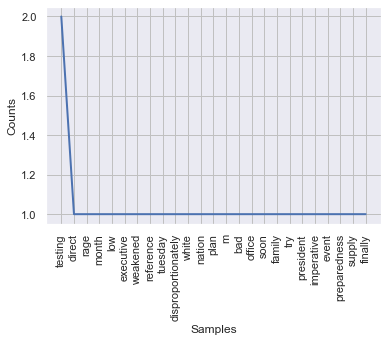

In [215]:
cfd['pandemic'].plot();

In [216]:
cfd['pandemic'].freq('testing')

0.07692307692307693

# Named-Entity Recognition

Named Entity Recognition (NER) is also a classification task, which identifies named objects. 
Like every other part of the pipeline, spaCy also tags words with their tagged entity (https://spacy.io/api/entityrecognizer). You can see the full capacity of what spaCy does by checking out: https://spacy.io/usage/linguistic-features.

For training the identification of such entities, spaCy uses a deep learning model.

Let's try it on a basic sentence:

In [217]:
sent = nlp(u"Tom went to IKEA to get some of those delicious Swedish meatballs.")

In [218]:
for token in sent:
    print(token.text, token.ent_type_)

Tom PERSON
went 
to 
IKEA ORG
to 
get 
some 
of 
those 
delicious 
Swedish NORP
meatballs 
. 


For only finding ents-

In [219]:
for ent in sent.ents:
    print(ent.text, ent.label_)

Tom PERSON
IKEA ORG
Swedish NORP


In [222]:
def tag_sents_ner(sentences):
    """
    function which replicates NLTK ner tagging on sentences.
    """
    new_sents = []
    for sentence in sentences:
        new_sent = ' '.join(sentence)
        new_sents.append(new_sent)
    final_string = ' '.join(new_sents)
    doc = nlp(final_string)
    
    pos_sents = []
    for sent in doc.sents:
        pos_sent = []
        for ent in sent.ents:
            pos_sent.append((ent.text, ent.label_))
        pos_sents.append(pos_sent)
    
    return pos_sents

We can also run NER over our entire corpus:

In [223]:
redditTopScores['classified_sents'] = redditTopScores['sentences'].apply(lambda x: tag_sents_ner(x))

In [229]:
redditTopScores[['classified_sents']]

,classified_sents
9,"[[(Last year, DATE)], [(one, CARDINAL)], [], [..."
8,"[[(First, ORDINAL)], [], [], [(today, DATE)], ..."
7,[[(my_26_f_with_my_husband_29_m_1_year_he_has_...
6,"[[(2004, DATE)], [], [], [(30,000, CARDINAL), ..."
5,"[[(Helpdesk, PERSON), (UK, GPE)], [], [], [], ..."
4,"[[], [(Engineer, PERSON)], [(All good, TIME)],..."
3,"[[(the out of hours, TIME)], [], [], [], [], [..."
2,"[[], [], [], [], [(4, CARDINAL)], [], [], [], ..."
1,"[[], [], [], [], [], [], [], [], [], [], [], [..."
0,"[[(normal day, DATE)], [], [], [(recently past..."


Find the most common entities (which are, of course, boring):

In [225]:
entityCounts = {}
for entry in redditTopScores['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if ent in entityCounts:
                entityCounts[ent] += 1
            else:
                entityCounts[ent] = 1
sortedEntities = sorted(entityCounts.items(), key = lambda x: x[1], reverse = True)
sortedEntities[:10]

[('Jack', 14),
 ('today', 8),
 ('one', 6),
 ('Smith', 6),
 ('Google Bing', 5),
 ('Boss', 5),
 ('4', 4),
 ('two', 4),
 ('9', 3),
 ('second', 3)]

Or those occurring only twice:

In [226]:
[x[0] for x in sortedEntities if x[1] == 2]

['Windows',
 'first',
 '3',
 '5',
 '10',
 'each day',
 '30k',
 'hours',
 'last week',
 'three',
 'Usr',
 'last Thursday']

We could also list the most common "non-objects". (We note that we're not graphing these because there are so few here.)

In [230]:
nonObjCounts = {}
for entry in redditTopScores['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind == 'ORG':
                continue
            elif ent in nonObjCounts:
                nonObjCounts[ent] += 1
            else:
                nonObjCounts[ent] = 1
sortedNonObj = sorted(nonObjCounts.items(), key = lambda x: x[1], reverse = True)
sortedNonObj[:10]

[('Jack', 14),
 ('today', 8),
 ('one', 6),
 ('Smith', 6),
 ('Google Bing', 5),
 ('4', 4),
 ('two', 4),
 ('Boss', 4),
 ('9', 3),
 ('second', 3)]

What about the Organizations?

In [228]:
OrgCounts = {}
for entry in redditTopScores['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind == 'ORG':
                print(ent)

Computer C O M P U T E
CAPITAL P. NUMBER FOUR
X'mas
6 Needless
picture](http://imgur.com
Email
REAL
POS
COM
CMD
UGHHHHH
Edit
Bing Search
Google Chrome
Caller
Boss Wife 's
Boss
USB
Boss 's Wife
Edit 2
TodaysDate
Proceed
Usr


These, of course, have much smaller counts.

In this particular example we didn't find the most interesting entities - you can remedy that in exercise 4!

## <span style="color:red">*Exercise 4*</span>

<span style="color:red">In the cells immediately following, perform NER on a (modest) subset of your corpus of interest. List all of the different kinds of entities tagged? What does their distribution suggest about the focus of your corpus? For a subset of your corpus, tally at least one type of named entity and calculate the Precision, Recall and F-score for the NER classification just performed.

In [231]:
doc = nlp(corpus_df['Speech Content'][0])

In [232]:
for token in doc.ents:
    print(token.text, token.label_)

afternoon TIME
Harris PERSON
Yesterday DATE
900,000 CARDINAL
Americans NORP
900,000 CARDINAL
millions CARDINAL
Americans NORP


In [233]:
corpus_df['classified_sents'] = corpus_df['Speech Content'].apply(lambda x: [(w.text, w.label_) for w in nlp(x).ents])

In [234]:
corpus_df['classified_sents']

0      [(afternoon, TIME), (Harris, PERSON), (Yesterd...
1      [(first, ORDINAL), (night, TIME), (hours, TIME...
2      [(the United States of America, GPE), (today, ...
3      [(Americans, NORP), (Americans, NORP), (tomorr...
4                                                     []
                             ...                        
108    [(the United States, GPE), (Biden, PERSON), (t...
109                             [(the early days, DATE)]
110    [(WHO, ORG), (WHO, ORG), (the United Nations, ...
111                               [(the next one, DATE)]
112                           [(the United States, GPE)]
Name: classified_sents, Length: 113, dtype: object

In [235]:
tag_count = {}
word_count = {}
for w, t in corpus_df['classified_sents'].sum():
    word_count[(w, t)] = word_count.get((w, t), 0) + 1
    tag_count[t] = tag_count.get(t, 0) + 1
tag_count = sorted(tag_count.items(), key = lambda x: x[1], reverse = True)
word_count = sorted(word_count.items(), key = lambda x: x[1], reverse = True)

In [237]:
tag_count[:10]

[('ORG', 105),
 ('DATE', 91),
 ('CARDINAL', 81),
 ('PERSON', 57),
 ('NORP', 54),
 ('GPE', 47),
 ('TIME', 18),
 ('ORDINAL', 16),
 ('PERCENT', 7),
 ('FAC', 6)]

In [238]:
word_count[:10]

[(('Americans', 'NORP'), 27),
 (('Senate', 'ORG'), 17),
 (('America', 'GPE'), 15),
 (('the United States', 'GPE'), 13),
 (('first', 'ORDINAL'), 11),
 (('today', 'DATE'), 10),
 (('American', 'NORP'), 10),
 (('COVID', 'ORG'), 9),
 (('Republican', 'NORP'), 9),
 (('WHO', 'ORG'), 9)]

In [239]:
[i for i in word_count if i[0][1] == 'ORG'][:10]

[(('Senate', 'ORG'), 17),
 (('COVID', 'ORG'), 9),
 (('WHO', 'ORG'), 9),
 (('Congress', 'ORG'), 8),
 (('Defense', 'ORG'), 5),
 (('The American Rescue Plan', 'ORG'), 3),
 (('the National Guard', 'ORG'), 3),
 (('FEMA', 'ORG'), 3),
 (('the World Health Organization', 'ORG'), 3),
 (('the American Rescue Plan', 'ORG'), 2)]

In [240]:
[i for i in word_count if i[0][1] == 'PERSON'][:10]

[(('Biden', 'PERSON'), 7),
 (('Donald Trump', 'PERSON'), 4),
 (('Harris', 'PERSON'), 3),
 (('Trump', 'PERSON'), 3),
 (('President', 'PERSON'), 2),
 (('Hank Aaron', 'PERSON'), 2),
 (('Lloyd Austin', 'PERSON'), 2),
 (('Austin', 'PERSON'), 2),
 (('McConnell', 'PERSON'), 2),
 (('Tony Fauci', 'PERSON'), 2)]

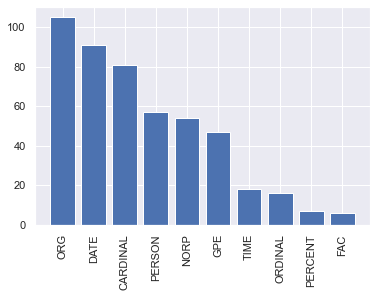

In [241]:
import matplotlib.pyplot as plt
top10tag = tag_count[:10]
plt.bar(range(len(top10tag)), list(dict(top10tag).values()), align='center')
plt.xticks(range(len(top10tag)), list(dict(top10tag).keys()), rotation=90);

## Dependency parsing and graph representations

Dependency parsing was developed to robustly capture linguistic dependencies from text. The complex tags associated with these parses are detailed [here]('http://universaldependencies.org/u/overview/syntax.html'). When parsing with the dependency parser, we will work directly from the untokenized text. Note that no *processing* takes place before parsing sentences--we do not remove so-called stop words or anything that plays a syntactic role in the sentence, although anaphora resolution and related normalization may be performed before or after parsing to enhance the value of information extraction. 

We will be using spaCy's built in dependancy parser to go about exploring the tree.
Note that unlike previous examples, large corpuses or collections of sentences don't give us as much information, so we will be navigating smaller sentences.

Let us start by exploring noun chunks. Noun chunks are “base noun phrases” – flat phrases that have a noun as their head. You can think of noun chunks as a noun plus the words describing the noun – for example, “the lavish green grass” or “the world’s largest tech fund”. To get the noun chunks in a document, simply iterate over the sentences noun chunks.

In [242]:
from spacy import displacy

In [243]:
doc = nlp("Autonomous cars shift insurance liability toward manufacturers")

In [244]:
displacy.render(doc, style='dep')

In [245]:
for chunk in doc.noun_chunks:
    print(chunk.text, chunk.root.text, chunk.root.dep_, chunk.root.head.text)

Autonomous cars cars nsubj shift
insurance liability liability dobj shift
manufacturers manufacturers pobj toward


spaCy uses the terms head and child to describe the words connected by a single arc in the dependency tree. The term dep is used for the arc label, which describes the type of syntactic relation that connects the child to the head. As with other attributes, the value of .dep is a hash value. You can get the string value with .dep_.

For your reference:

Text: The original token text.

Dep: The syntactic relation connecting child to head.

Head text: The original text of the token head.

Head POS: The part-of-speech tag of the token head.

Children: The immediate syntactic dependents of the token.

In [251]:
for token in doc:
    print(token.text, token.dep_, token.head.text, token.head.pos_,
            [child for child in token.children])

bright amod apples NOUN []
red amod apples NOUN []
apples ROOT apples NOUN [bright, red, on]
on prep apples NOUN [tree]
the det tree NOUN []
tree pobj on ADP [the]


Because the syntactic relations form a tree, every word has exactly one head. You can therefore iterate over the arcs in the tree by iterating over the words in the sentence. This is usually the best way to match an arc of interest — from below:

In [246]:
from spacy.symbols import nsubj, VERB

In [247]:
verbs = set()
for possible_subject in doc:
    if possible_subject.dep == nsubj and possible_subject.head.pos == VERB:
        verbs.add(possible_subject.head)
print(verbs)

{shift}


You can *also* navigate from above. It isn't as efficient though.

In [248]:
verbs = []
for possible_verb in doc:
    if possible_verb.pos == VERB:
        for possible_subject in possible_verb.children:
            if possible_subject.dep == nsubj:
                verbs.append(possible_verb)
                break

In [249]:
print(verbs)

[shift]


### Iterating around the local tree
A few more convenience attributes are provided for iterating around the local tree from the token. Token.lefts and Token.rights attributes provide sequences of syntactic children that occur before and after the token. Both sequences are in sentence order. There are also two integer-typed attributes, Token.n_lefts and Token.n_rights that give the number of left and right children.

In [250]:
doc = nlp("bright red apples on the tree")
print([token.text for token in doc[2].lefts])  # ['bright', 'red']
print([token.text for token in doc[2].rights])  # ['on']
print(doc[2].n_lefts)  # 2
print(doc[2].n_rights)  # 1

['bright', 'red']
['on']
2
1


You can get a whole phrase by its syntactic head using the Token.subtree attribute. This returns an ordered sequence of tokens. You can walk up the tree with the Token.ancestors attribute, and check dominance with Token.is_ancestor

In [252]:
doc = nlp("Credit and mortgage account holders must submit their requests")

root = [token for token in doc if token.head == token][0]
subject = list(root.lefts)[0]
for descendant in subject.subtree:
    assert subject is descendant or subject.is_ancestor(descendant)
    print(descendant.text, descendant.dep_, descendant.n_lefts,
            descendant.n_rights,
            [ancestor.text for ancestor in descendant.ancestors])

Credit nmod 0 2 ['holders', 'submit']
and cc 0 0 ['Credit', 'holders', 'submit']
mortgage compound 0 0 ['account', 'Credit', 'holders', 'submit']
account conj 1 0 ['Credit', 'holders', 'submit']
holders nsubj 1 0 ['submit']


Finally, the .left_edge and .right_edge attributes can be especially useful, because they give you the first and last token of the subtree. This is the easiest way to create a Span object for a syntactic phrase. Note that .right_edge gives a token within the subtree — so if you use it as the end-point of a range, don’t forget to +1!

In [253]:
span = doc[doc[4].left_edge.i : doc[4].right_edge.i+1]
with doc.retokenize() as retokenizer:
    retokenizer.merge(span)
for token in doc:
    print(token.text, token.pos_, token.dep_, token.head.text)

Credit and mortgage account holders NOUN nsubj submit
must VERB aux submit
submit VERB ROOT submit
their DET poss requests
requests NOUN dobj submit


In [254]:
displacy.render(doc, style='dep')

### Information Extraction

How can dependancy graphs be useful? We can extract information from the sentences based on relationships between words within parsed phrases. Let us see if we can do this to glean any information, from, say, our movies dataset. 

How violent are the movies? Who is killing who?

In [255]:
movie_violences = {}

In [259]:
for index, row in movie_df.iterrows():
    text = ' '.join(row['Tokenized Texts'])
    movie_violences[row['Movie Name']] = ([], [])
    doc = nlp(text)
    for chunk in doc.noun_chunks:
        subject = 0
        object_ = 0
        # if the verb or the root of the sentence is kill
        if chunk.root.head.text == 'kill':
            # we find the subjects and objects around the word, and if it does exist, add it to the tuple
            if chunk.root.dep_ == 'nsubj':
                subject = chunk.root.text
            if chunk.root.dep_ == 'dobj':
                object_ = chunk.root.text
            if subject != 0:
                movie_violences[row['Movie Name']][0].append(subject)
            if object_ != 0:
                movie_violences[row['Movie Name']][1].append(object_)

KeyboardInterrupt: 

In [ ]:
movie_violences

That's pretty neat: we can see who tried to kill who, or at least talked about it. A lot of 'I' killing 'you', as we'd imagine. What else can we see?

The movie, about time, which is about time travel, funnily enough has:
`'About Time': (['I'], ['Hitler'])`

## <span style="color:red">*Your turn*</span>

<span style="color:red">In the cells immediately following, parse a (modest) subset of your corpus of interest. How deep are the phrase structure and dependency parse trees nested? How does parse depth relate to perceived sentence complexity? What are five things you can extract from these parses for subsequent analysis? (e.g., nouns collocated in a noun phrase; adjectives that modify a noun; etc.) Capture these sets of things for a focal set of words (e.g., "Bush", "Obama", "Trump"). What do they reveal about the roles that these entities are perceive to play in the social world inscribed by your texts?

In [260]:
s = ' '.join(corpus_df['sentences'][2][1])

In [261]:
doc = nlp(s)

In [263]:
displacy.render(doc, style='dep')

In [264]:
for token in doc:
    print(token.text, token.dep_, token.head.text, token.head.pos_,
            [child for child in token.children])

Folks nsubj seen VERB [are]
who nsubj are AUX []
are relcl Folks NOUN [who, able]
able acomp are AUX [keep]
to aux keep VERB []
still advmod keep VERB []
keep xcomp able ADJ [to, still, job]
their poss job NOUN []
job dobj keep VERB [their]
many nsubj seen VERB []
have aux seen VERB []
seen ROOT seen VERB [Folks, many, have, reduced, and, hanging]
their poss paychecks NOUN []
paychecks nsubj reduced VERB [their]
reduced ccomp seen VERB [paychecks]
and cc seen VERB []
they nsubj hanging VERB []
’re aux hanging VERB []
barely advmod hanging VERB []
hanging conj seen VERB [they, ’re, barely, on, and, wondering]
on prt hanging VERB []
and cc hanging VERB []
wondering conj hanging VERB [what]
what dobj wondering VERB [’s, next]
’s punct what PRON []
next advmod what PRON []


In [265]:
from spacy.symbols import nsubj, VERB

In [266]:
verbs = set()
for possible_subject in doc:
    if possible_subject.dep == nsubj and possible_subject.head.pos == VERB:
        verbs.add(possible_subject.head)
print(verbs)

{reduced, seen, hanging}


In [267]:
root = [token for token in doc if token.head == token][0]
subject = list(root.lefts)[0]
for descendant in subject.subtree:
    assert subject is descendant or subject.is_ancestor(descendant)
    print(descendant.text, descendant.dep_, descendant.n_lefts,
            descendant.n_rights,
            [ancestor.text for ancestor in descendant.ancestors])

Folks nsubj 0 1 ['seen']
who nsubj 0 0 ['are', 'Folks', 'seen']
are relcl 1 1 ['Folks', 'seen']
able acomp 0 1 ['are', 'Folks', 'seen']
to aux 0 0 ['keep', 'able', 'are', 'Folks', 'seen']
still advmod 0 0 ['keep', 'able', 'are', 'Folks', 'seen']
keep xcomp 2 1 ['able', 'are', 'Folks', 'seen']
their poss 0 0 ['job', 'keep', 'able', 'are', 'Folks', 'seen']
job dobj 1 0 ['keep', 'able', 'are', 'Folks', 'seen']


In [268]:
span = doc[doc[4].left_edge.i : doc[4].right_edge.i+1]
with doc.retokenize() as retokenizer:
    retokenizer.merge(span)
for token in doc:
    print(token.text, token.pos_, token.dep_, token.head.text)

Folks NOUN nsubj seen
who PRON nsubj are
are AUX relcl Folks
able ADJ acomp are
to PART aux keep
still ADV advmod keep
keep VERB xcomp able
their DET poss job
job NOUN dobj keep
many ADJ nsubj seen
have AUX aux seen
seen VERB ROOT seen
their DET poss paychecks
paychecks NOUN nsubj reduced
reduced VERB ccomp seen
and CCONJ cc seen
they PRON nsubj hanging
’re VERB aux hanging
barely ADV advmod hanging
hanging VERB conj seen
on ADV prt hanging
and CCONJ cc hanging
wondering VERB conj hanging
what PRON dobj wondering
’s VERB punct what
next ADJ advmod what


In [274]:
actions = {}
for index, row in corpus_df.iterrows():
    text = ' '.join(row['tokenized_text'])
    doc = nlp(text)
    for chunk in doc.noun_chunks:
        lst = []
        subject = 0
        object_ = 0
        verb = chunk.root.head.text
        if chunk.root.dep_ == 'nsubj':
            subject = chunk.root.text
        if chunk.root.dep_ == 'dobj':
            object_ = chunk.root.text
        if object_ != 0:
            lst.append(object_)
        lst.append(verb)
        if subject != 0:
            lst.append(subject)
    if len(lst) > 1:
        actions[row['Speaker']] = actions.get(row['Speaker'], []) + [lst]

In [275]:
actions['President Joe Biden']

[['themselves', 'did'],
 ['’re', 'they'],
 ['it', 'need'],
 ['schools', 'reopening'],
 ['jobs', 'losing'],
 ['community', 'reduce'],
 ['take', 'we'],
 ['hurting', 'who'],
 ['it', 'turn'],
 ['make', 'Department'],
 ['need', 'we'],
 ['them', 'use'],
 ['order', 'sign'],
 ['you', 'Thank'],
 ['crises', 'meet'],
 ['effort', 'managing'],
 ['daughters', 'remember'],
 ['needed', 'we'],
 ['get', 'we'],
 ['plan', 'put'],
 ['workforce', 'grow'],
 ['lives', 'going'],
 ['plan', 'move'],
 ['centers', 'reopen'],
 ['make', 'we'],
 ['mistake', 'make'],
 ['you', 'Thank'],
 ['workers', 'keeping'],
 ['hand', 'give'],
 ['you', 'Thank'],
 ['you', 'Thank']]

# Distributional distances

If we want to compare different corpora, we need a distance or divergence that compares the two distributions.

We will use the: 

+ Kullback-Leibler (KL) divergence
+ $\chi^2$ divergence
+ Kolmogorov-Smirnov (KS) distance
+ Wasserstein distance

### Kullback-Leibler and $x^2$ divergences ###

KL and $\chi^2$ divergences are members of the broader <a "href=https://en.wikipedia.org/wiki/F-divergence" target="_blank">$f$-divergence</a> family, a function of $D_f (P || Q)$ that calculates the difference between two probability distributions P and Q. The KL $f(t)$ is $ t \text{ log } t $, while the $\chi^2$ is $t^2-1$. KL comes from information and $\chi^2$ from measure theory. As such, the KL divergence computes the relative entropy between two distributions--how they differ in bits, while the $\chi^2$ whether the same statistical inferences can be drawn from them both.  

Specifically, given two discrete probability distributions $P$ and $Q$, the Kullback-Leibler divergence from $Q$ to $P$ is defined as:

$D_{\mathrm{KL}}(P\|Q) = \sum_i P(i) \, \log\frac{P(i)}{Q(i)}$.

The [scipy.stats.entropy()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.entropy.html) function does the calculation for you, which takes in two arrays of probabilities and computes the KL divergence. Note that the KL divergence is in general not commutative, i.e. $D_{\mathrm{KL}}(P\|Q) \neq D_{\mathrm{KL}}(Q\|P)$ .

Also note that the KL divernce is the sum of elementwise divergences. Scipy provides [scipy.special.kl_div()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.kl_div.html#scipy-special-kl-div) which calculates elementwise divergences for you.

The $\chi^2$ Divergence is defined as:

$D_{\mathrm{\chi^2}}(P\|Q) = \sum_i \left(\frac{P(i)}{Q(i)}-1\right)^2$. 

This is also noncommutative, and the code can be drawn directly from scipy.

### Kolmogorov-Smirnov ###

The two-sample Kolmogovorov-Smirnov test statistic calculates the distance between the cumulative distribution function of the two distributions to be compared, and, along with the $x^2$ divergence, is among the most common approaches two calculating a distance in statistics. It can be interpreted as a test of whether two distributions are drawn from the same underlying distribution. As with the others, the code is readily available in scipy.

### Wasserstein Distance ###

When this is computed on a Euclidian metric structure (e.g., numbers of words), this is also known as the earth mover’s distance, because it can be seen as the minimum amount of "work" required to transform $P$ into $Q$, where "work" is measured as the amount of distribution weight that must be moved, multiplied by the distance it has to be moved.

### Computing ###

To do this we will need to create the arrays, lets compare the Whitehouse releases with the Kennedy releases. First we have to download them and load them into a DataFrame.

In [276]:
kenReleases = getGithubFiles('https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Kennedy', maxFiles = 10)
kenReleases[:5]

,name,text,path,html_url,download_url
0,01Apr2005Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,raw/Kennedy/01Apr2005Kennedy14.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...
1,01Aug2005Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,raw/Kennedy/01Aug2005Kennedy12.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...
2,01Aug2006Kennedy10.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,raw/Kennedy/01Aug2006Kennedy10.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...
3,01Aug2006Kennedy11.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,raw/Kennedy/01Aug2006Kennedy11.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...
4,01Aug2006Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,raw/Kennedy/01Aug2006Kennedy12.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...


Then we can tokenize, stem and remove stop words, like we did for the Whitehouse press releases

In [277]:
kenReleases['tokenized_text'] = kenReleases['text'].apply(lambda x: word_tokenize(x))
kenReleases['normalized_tokens'] = kenReleases['tokenized_text'].apply(lambda x: normalizeTokens(x))

In [279]:
kenReleases[:5]

,name,text,path,html_url,download_url,tokenized_text,normalized_tokens
0,01Apr2005Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,raw/Kennedy/01Apr2005Kennedy14.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,"[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...","[immediate, release, immediate, release, conta..."
1,01Aug2005Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,raw/Kennedy/01Aug2005Kennedy12.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,"[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...","[immediate, release, immediate, release, conta..."
2,01Aug2006Kennedy10.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,raw/Kennedy/01Aug2006Kennedy10.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,"[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...","[immediate, release, immediate, release, washi..."
3,01Aug2006Kennedy11.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,raw/Kennedy/01Aug2006Kennedy11.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,"[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...","[immediate, release, immediate, release, washi..."
4,01Aug2006Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,raw/Kennedy/01Aug2006Kennedy12.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,"[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...","[immediate, release, immediate, release, conta..."


Now we need to compare the two collection of words, remove those not found in both, and assign the remaining ones indices.

In [284]:
whWords = set(whReleases['normalized_tokens'].sum())
kenWords = set(kenReleases['normalized_tokens'].sum())

#Change & to | if you want to keep all words
overlapWords = whWords & kenWords

overlapWordsDict = {word: index for index, word in enumerate(overlapWords)}
overlapWordsDict

{'project': 0,
 'general': 1,
 'cover': 2,
 'day': 3,
 'instead': 4,
 'august': 5,
 'staff': 6,
 'consider': 7,
 'fear': 8,
 'relate': 9,
 'lose': 10,
 'irresponsible': 11,
 'challenge': 12,
 'free': 13,
 'currently': 14,
 'provide': 15,
 'court': 16,
 'long': 17,
 'bring': 18,
 'issue': 19,
 'year': 20,
 'determine': 21,
 'stand': 22,
 'reiterate': 23,
 'high': 24,
 'pende': 25,
 'tell': 26,
 'necessary': 27,
 'science': 28,
 'employ': 29,
 'insurance': 30,
 'start': 31,
 'agenda': 32,
 'call': 33,
 'appear': 34,
 'view': 35,
 'community': 36,
 'life': 37,
 'follow': 38,
 'number': 39,
 'concerned': 40,
 'hope': 41,
 'face': 42,
 'request': 43,
 'regular': 44,
 'million': 45,
 'country': 46,
 'see': 47,
 'great': 48,
 'drug': 49,
 'far': 50,
 'come': 51,
 'place': 52,
 'nominee': 53,
 'effort': 54,
 'consideration': 55,
 'conduct': 56,
 'eligible': 57,
 'committee': 58,
 'deny': 59,
 'rank': 60,
 'person': 61,
 'federal': 62,
 'm': 63,
 'addition': 64,
 'american': 65,
 'evidence': 66

Now we can count the occurrences of each word in the corpora and create our arrays. Note that we don't have to use numpy arrays as we do here. We could just use a list, but the arrays are faster in numpy so we encourage you to get in the habit of using them.

In [285]:
def makeProbsArray(dfColumn, overlapDict):
    words = dfColumn.sum()
    countList = [0] * len(overlapDict)
    for word in words:
        try:
            countList[overlapDict[word]] += 1
        except KeyError:
            #The word is not common so we skip it
            pass
    countArray = np.array(countList)
    return countArray / countArray.sum()

whProbArray = makeProbsArray(whReleases['normalized_tokens'], overlapWordsDict)
kenProbArray = makeProbsArray(kenReleases['normalized_tokens'], overlapWordsDict)
kenProbArray.sum()
#There is a little bit of a floating point math error
#but it's too small to see with print and too small matter here

1.0

We can now compute the KL divergence. Pay attention to the asymmetry. Use [the Jensen–Shannon divergence](https://en.wikipedia.org/wiki/Jensen%E2%80%93Shannon_divergence), which is the average KL divergence between each distribution and the average of both distributions (i.e., the midpoint), if you want symmetry.

In [287]:
wh_kenDivergence = scipy.stats.entropy(whProbArray, kenProbArray)
print (wh_kenDivergence)
ken_whDivergence = scipy.stats.entropy(kenProbArray, whProbArray)
print (ken_whDivergence)

0.632501503520831
0.5771554290773404


Then, we can do the elementwise calculation and see which words best distinguish the two corpora.

In [288]:
wh_kenDivergence_ew = scipy.special.kl_div(whProbArray, kenProbArray)
kl_df = pandas.DataFrame(list(overlapWordsDict.keys()), columns = ['word'], index = list(overlapWordsDict.values()))
kl_df = kl_df.sort_index()
kl_df['elementwise divergence'] = wh_kenDivergence_ew
kl_df[:10]

,word,elementwise divergence
0,project,0.000069
1,general,0.004342
2,cover,0.000383
3,day,0.001183
4,instead,0.002171
5,august,0.000069
6,staff,0.005820
7,consider,0.000276
8,fear,0.000058
9,relate,0.000838


In [289]:
kl_df.sort_values(by='elementwise divergence', ascending=False)[:10]

,word,elementwise divergence
145,iraq,0.095968
116,bush,0.048799
65,american,0.026266
271,stem,0.024023
228,law,0.022691
121,department,0.020102
106,member,0.013466
154,war,0.012838
189,program,0.011116
46,country,0.010339


Now we will apply what we learned today 
First, let's transform every text into normalized tokens. Note that in this first step, no stopword is removed.
We'll use only the first 11 movies: you are welcome to try more.

In [292]:
corpora = []
for index, row in movie_df.iterrows():
    if len(corpora) > 10:
        break
    corpora.append(row['Tokenized Texts'])

In [293]:
corpora

[['You',
  'must',
  'do',
  'your',
  'best',
  'tonight',
  'Be',
  'on',
  'your',
  'toes',
  'men',
  'There',
  "'s",
  'another',
  'guest',
  'tonight',
  'It',
  "'s",
  'one',
  'of',
  'those',
  'men',
  'Who',
  'are',
  'being',
  'feted',
  'by',
  'the',
  'smart',
  'set',
  'We',
  "'ll",
  'see',
  'that',
  'he',
  'gets',
  'what',
  'he',
  'deserves',
  'Treat',
  'him',
  'as',
  'they',
  'do',
  'a',
  'king',
  'in',
  'manner',
  'royal',
  'Like',
  'a',
  'subject',
  'to',
  'a',
  'king',
  'you',
  'must',
  'be',
  'loyal',
  'On',
  'this',
  'object',
  'you',
  'must',
  'have',
  'your',
  'heart',
  'set',
  'We',
  "'ll",
  'do',
  'nothing',
  'to',
  'get',
  'on',
  'his',
  'nerves',
  'Again',
  'I',
  'mention',
  'Be',
  'on',
  'your',
  'toes',
  'men',
  'He',
  'craves',
  'attention',
  'He',
  "'s",
  'one',
  'of',
  'those',
  'men',
  'Yes',
  'sir',
  'we',
  'will',
  'give',
  'him',
  'just',
  'what',
  'he',
  'deserves',
  

Then, let's separate the normalized tokens into stopwords and non-stopwords.

In [300]:
corpora_s = []
corpora_nons = []
for corpus in corpora:
    s = []
    nons = []
    doc = nlp(' '.join(corpus))
    for word in doc:
        if word.is_stop:
            s.append(word.text)
        else:
            nons.append(word.text)
    corpora_s.append(s)
    corpora_nons.append(nons)

[['best',
  'tonight',
  'toes',
  'men',
  'guest',
  'tonight',
  'men',
  'feted',
  'smart',
  'set',
  'gets',
  'deserves',
  'Treat',
  'king',
  'manner',
  'royal',
  'Like',
  'subject',
  'king',
  'loyal',
  'object',
  'heart',
  'set',
  'nerves',
  'mention',
  'toes',
  'men',
  'craves',
  'attention',
  'men',
  'Yes',
  'sir',
  'deserves',
  'Oh',
  'Hives',
  'Oh',
  'yes',
  'Mrs',
  'Rittenhouse',
  'like',
  'changes',
  'assignment',
  'rooms',
  'good',
  'madam',
  'Suppose',
  'Mr',
  'Chandler',
  'blue',
  'suite',
  'Captain',
  'Spaulding',
  'guest',
  'honor',
  'green',
  'duplex',
  'baths',
  'madam',
  'yes',
  'think',
  'Captain',
  'like',
  'baths',
  'returned',
  'Roscoe',
  'W',
  'Chandler',
  'Mrs',
  'Rittenhouse',
  'Mr',
  'Chandler',
  'nice',
  'famous',
  'Beaugard',
  'promised',
  'Mr',
  'Chandler',
  'express',
  'gratitude',
  'Oh',
  'return',
  'Europe',
  'masterpiece',
  'valued',
  '$',
  '100,000',
  'instead',
  'displayi

Define some covenient funtions for calculating divergence and distances.

In [295]:
def kl_divergence(X, Y):
    P = X.copy()
    Q = Y.copy()
    P.columns = ['P']
    Q.columns = ['Q']
    df = Q.join(P).fillna(0)
    p = df.iloc[:,1]
    q = df.iloc[:,0]
    D_kl = scipy.stats.entropy(p, q)
    return D_kl

def chi2_divergence(X,Y):
    P = X.copy()
    Q = Y.copy()
    P.columns = ['P']
    Q.columns = ['Q']
    df = Q.join(P).fillna(0)
    p = df.iloc[:,1]
    q = df.iloc[:,0]
    return scipy.stats.chisquare(p, q).statistic

def Divergence(corpus1, corpus2, difference="KL"):
    """Difference parameter can equal KL, Chi2, or Wass"""
    freqP = nltk.FreqDist(corpus1)
    P = pandas.DataFrame(list(freqP.values()), columns = ['frequency'], index = list(freqP.keys()))
    freqQ = nltk.FreqDist(corpus2)
    Q = pandas.DataFrame(list(freqQ.values()), columns = ['frequency'], index = list(freqQ.keys()))
    if difference == "KL":
        return kl_divergence(P, Q)
    elif difference == "Chi2":
        return chi2_divergence(P, Q)
    elif difference == "KS":
        try:
            return scipy.stats.ks_2samp(P['frequency'], Q['frequency']).statistic
        except:
            return scipy.stats.ks_2samp(P['frequency'], Q['frequency'])
    elif difference == "Wasserstein":
        try:
            return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None).statistic
        except:
            return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None)

Now we will calculate the KL divergence for each pair of corpora, turn the results into a matrix, and visualize the matrix as a heatmap. Recall that $D_{\mathrm{KL}}(P\|Q)$ measures the amount of information loss when $Q$ is used to approximate $P$. Here, the rows are the $P$s used for calculating KL divergences, and the columns are the $Q$s. So, each cell measures the amount of information loss when the word distribution of the column text is used to approximate the word distribution of the row text. Because the KL divergence is directional, such that the divergence of $P$ from $Q$ is different from the same of $Q$ from $P$, the matrix is assymetric and contains unique information above and below the diagonal. The same is true for the $\chi^2$ divergence.

In [296]:
len(corpora)

11

In [297]:
fileids = list(movie_df['Movie Name'])[0:11]

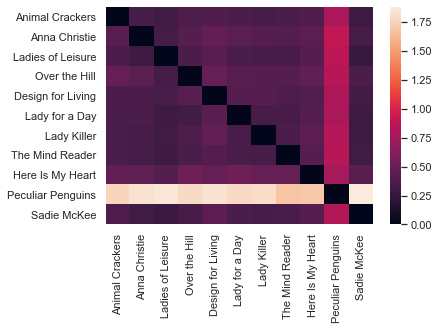

In [298]:
L = []
for p in corpora:
    l = []
    for q in corpora:
        l.append(Divergence(p,q, difference = 'KL'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()


To reveal more patterns, let's do a multidimensional scaling of the matrix.

/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


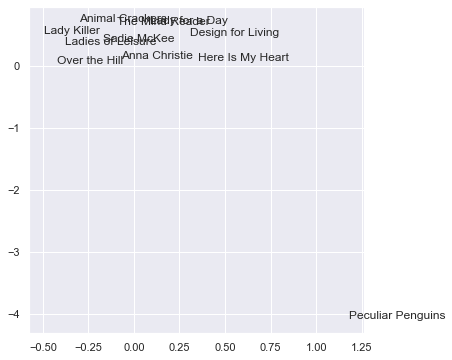

In [304]:
mds = sklearn.manifold.MDS()
pos = mds.fit(M).embedding_
x = pos[:,0]
y = pos[:,1]
fig, ax = plt.subplots(figsize = (6,6))
plt.plot(x, y, ' ')
for i, txt in enumerate(fileids):
    ax.annotate(txt, (x[i],y[i]))

A co-respondent's course and The Chain Gang are away from the others - any guesses why?

We may just want to focus on the distrbution of stopwords or non-stopwords. Let's do the analysis again first for stopwords and then for non-stopwords.

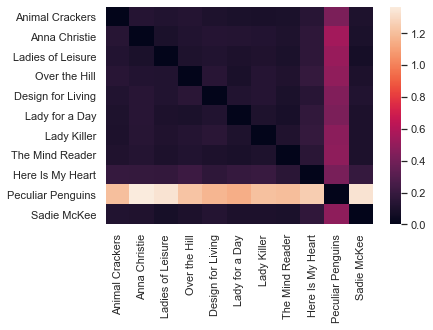

In [305]:
L = []
for p in corpora_s:
    l = []
    for q in corpora_s:
        l.append(Divergence(p,q, difference='KL'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

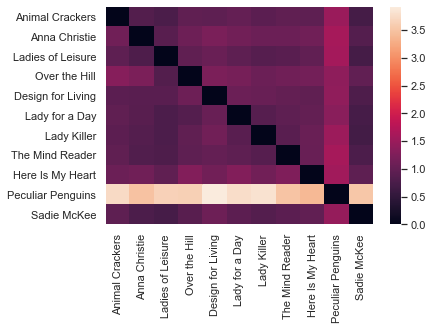

In [306]:
L = []
for p in corpora_nons:
    l = []
    for q in corpora_nons:
        l.append(Divergence(p,q, difference='KL'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

Now we compute the same for the assymmetric $\chi^2$ Divergence.

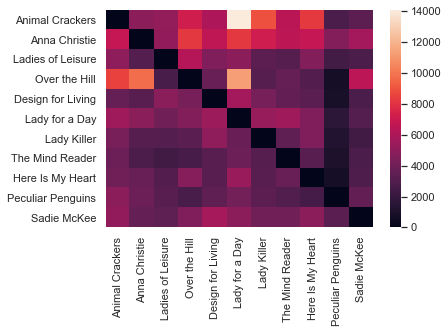

In [307]:
L = []
for p in corpora_nons:
    l = []
    for q in corpora_nons:
        l.append(Divergence(p,q, difference='Chi2'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

For the KS distance:

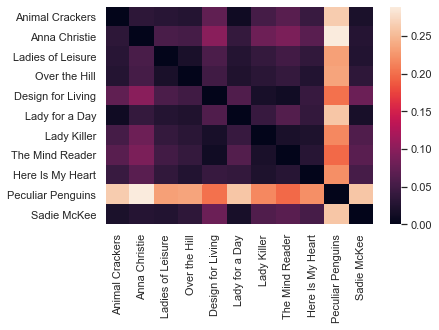

In [308]:
L = []
for p in corpora_nons:
    l = []
    for q in corpora_nons:
        l.append(Divergence(p,q, difference='KS'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

And finally for the Wasserstein or "earth mover's" Distance.

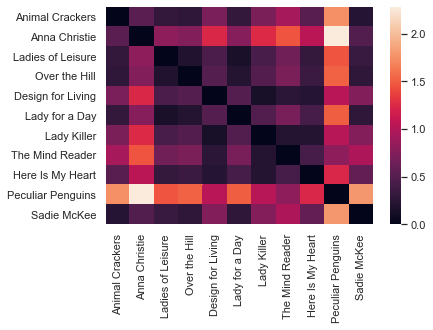

In [309]:
L = []
for p in corpora_nons:
    l = []
    for q in corpora_nons:
        l.append(Divergence(p,q, difference='Wasserstein'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

You can see that decade X is highly divergent and this makes reading the plot somewhat difficult. Let's fix this by taking the log of each cell, which will reduce the distance of decode X from other texts as an outlier.

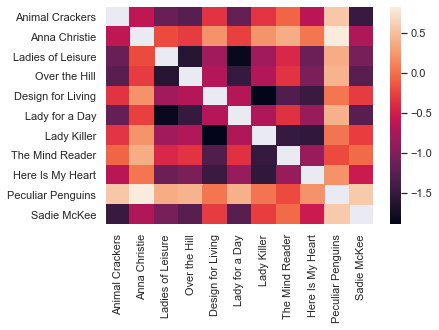

In [310]:
ax = sns.heatmap(div.apply(np.log).replace([np.inf, -np.inf], np.nan))
plt.show()

We only tried 11 movies, and from the same time period, so our signals might not be too interesting. What about different time periods?

An interesting experiment to maybe get some clearer signals: documents by decade in the Davies Corpus Of Historial American English (COHA) and see if we can detect patterns between them. 

If we want to rerun this on a new data set of our own composition, we can be a bit more efficient with our coding. Let's use the Shakespeare texts from last week as example: 

In [ ]:
shakespeare_df = lucem_illud_2020.loadTextDirectory('../data/Shakespeare')

Now we stem and remove stopwords

In [ ]:
shakespeare_df['tokenized_text'] = shakespeare_df['text'].apply(lambda x: word_tokenize(x))
shakespeare_df['normalized_tokens'] = shakespeare_df['tokenized_text'].apply(lambda x: normalizeTokens(x))

Create the corpus file and generate the heatmap:

In [ ]:
measure = 'KS' #"KL", "Chi2", "KS", "Wasserstein"
num_of_texts = 10 #The bigger this number the slower it will run, you can also try selecting your own plays
fileids_sp = list(shakespeare_df[:num_of_texts].index)
corpora_sp = list(shakespeare_df[:num_of_texts]['normalized_tokens'])
L = []
for p in corpora_sp:
    l = []
    for q in corpora_sp:
        l.append(Divergence(p,q, difference=measure))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids_sp, index = fileids_sp)
ax = sns.heatmap(div)
plt.show()

What are "The Passionate Pilgrim" and "The Phoenix and the Turtle"? Little known poems by Shakespeare that are unsurprisingly hard to classify, as they are so different from everything else he wrote.

## <span style="color:red">*Exercise 6*</span>

<span style="color:red">Construct cells immediately below this that calculate the KL and $\chi^2$ divergences, and the KS and Wasserstein distances between four separate corpora, plot these with heatmaps, and then array them in two dimensions with multidimensional scaling as above. What does this reveal about relations between the corpora? Which analysis (and divergence or distribution) distinguishes the authors or documents better? 

<span style="color:red">**Stretch**: Calculate the <a "href=https://en.wikipedia.org/wiki/Jensen–Shannon_divergence" target="_blank">Jensen-Shannon Divergence</a> between your four corpora. What is the relationship between the KL and JS divergences?</span> 

In [312]:
#get links for Trump speeches related to COVID
import bs4
req_trump = requests.get('https://www.rev.com/blog/transcripts?s=trump+covid')
soup_trump = bs4.BeautifulSoup(req_trump.text, 'html.parser')
a_trump = soup_trump.find_all('div', class_ = 'fl-post-grid')[0].find_all('a')
trump_links = [i['href'] for i in a_trump]

In [313]:
#get links for Biden speeches related to COVID
req_biden = requests.get('https://www.rev.com/blog/transcripts?s=biden+covid')
soup_biden = bs4.BeautifulSoup(req_biden.text, 'html.parser')
a_biden = soup_biden.find_all('div', class_ = 'fl-post-grid')[0].find_all('a')
biden_links = [i['href'] for i in a_biden]

In [317]:
import re
def getTextFromURLs(urls):
    '''
    Takes a list of urls and returns a DataFrame object.
    '''
    
    df_main = pd.DataFrame(columns=['Paragraph No', 'Speech Date', 'Speaker',
                                    'Speech Title', 'Speech Content', 'Speech Summary'])
    for url in urls:
        req = requests.get(url)
        soup = bs4.BeautifulSoup(req.text, 'html.parser')
        p = soup.find_all('p')
        df = pd.DataFrame(columns=['Paragraph No', 'Speech Date', 'Speaker',
                                 'Speech Title', 'Speech Content', 'Speech Summary'])
        p_no = []
        content = []
        speaker = []
        title = [re.sub('\n', '', soup.head.text)] * len(p[5:-1])
        date = [p[0].text] * len(p[5:-1])
        info = [p[1].text] * len(p[5:-1])
        for i, par in enumerate(p[5:-1]):
            p_no.append(i)
            text = re.sub(r'\(\d+\:\d+\)\n', '',par.text)
            text = re.sub(r'\[.*\]\s+', '', text) #to eliminate text like "[inaudible 00:04:25]"
            if len(text) < 3:
                continue
            if re.search(':', text) != None:
                speak = re.search(':', text).start()
                speaker.append(text[:speak])
                text = text[speak + 1:]
            else:
                speaker.append(None)
            content.append(text.strip())
            
        
        df['Paragraph No'] = p_no
        df['Speech Date'] = date
        df['Speech Summary'] = info
        df['Speech Content'] = content
        df['Speaker'] = speaker
        df['Speech Title'] = title
                
        df_main = pd.concat([df_main, df], axis=0)
        
    return df_main.reset_index(drop=True)

In [318]:
biden_df = getTextFromURLs(biden_links)
trump_df = getTextFromURLs(trump_links)

In [319]:
for df in [biden_df, trump_df]:    
    df['tokenized_text'] = df['Speech Content'].apply(lambda x: lucem_illud.word_tokenize(x))
    df['normalized_tokens'] = df['tokenized_text'].apply(lambda x: normalizeTokens(x, stop_words_freq))
    df['normalized_tokens_count'] = df['normalized_tokens'].apply(lambda x: len(x))

In [320]:
biden_df_clean = biden_df[biden_df['Speaker'].str.contains('Biden')]
trump_df_clean = trump_df[trump_df['Speaker'].str.contains('Trump')]

In [321]:
trump_words = set(trump_df_clean['normalized_tokens'].sum())
biden_words = set(biden_df_clean['normalized_tokens'].sum())

overlap = trump_words & biden_words
overlap_dict = {w : i for i, w in enumerate(overlap)}
overlap_dict

{'general': 0,
 'young': 1,
 'consensus': 2,
 'business': 3,
 'try': 4,
 'hi': 5,
 'remember': 6,
 'oh': 7,
 'chance': 8,
 'manufacturing': 9,
 'harris': 10,
 'long': 11,
 'outside': 12,
 'stand': 13,
 'century': 14,
 'tell': 15,
 'mention': 16,
 'call': 17,
 'view': 18,
 'promise': 19,
 'inside': 20,
 'growth': 21,
 'capital': 22,
 'negotiate': 23,
 'bed': 24,
 'million': 25,
 'actually': 26,
 'place': 27,
 'come': 28,
 'effort': 29,
 'sign': 30,
 'tribe': 31,
 'happen': 32,
 'essential': 33,
 'trouble': 34,
 'create': 35,
 'god': 36,
 'm': 37,
 'mile': 38,
 'heal': 39,
 'press': 40,
 'pretty': 41,
 'position': 42,
 'yes': 43,
 'especially': 44,
 'arm': 45,
 'terrible': 46,
 'suppose': 47,
 'able': 48,
 'doctor': 49,
 'prosperity': 50,
 'dr': 51,
 'bipartisan': 52,
 'world': 53,
 'crosstalk': 54,
 'find': 55,
 'game': 56,
 'include': 57,
 'fact': 58,
 'emergency': 59,
 'want': 60,
 'wave': 61,
 'recognize': 62,
 'services': 63,
 'throw': 64,
 'certify': 65,
 'build': 66,
 'catch': 67,

In [322]:
def makeProbArray(col, over_dict):
    words = col.sum()
    count_list = [0] * len(over_dict)
    for word in words:
        if word in over_dict.keys():
            count_list[over_dict[word]] += 1
    count_array = np.array(count_list)
    prob_array = count_array / sum(count_array)
    return prob_array

In [323]:
biden_prob_array = makeProbArray(biden_df_clean['normalized_tokens'], overlap_dict)
trump_prob_array = makeProbArray(trump_df_clean['normalized_tokens'], overlap_dict)

In [324]:
biden_trumpDivergence = scipy.stats.entropy(biden_prob_array, trump_prob_array)
print (biden_trumpDivergence)
trump_bidenDivergence = scipy.stats.entropy(trump_prob_array, biden_prob_array)
print (trump_bidenDivergence)

0.5041770147648192
0.503043645136566


In [325]:
biden_trumpDivergence_ew = scipy.special.kl_div(biden_prob_array, trump_prob_array)
kl_df = pandas.DataFrame(list(overlap_dict.keys()), columns = ['word'], index = list(overlap_dict.values()))
kl_df = kl_df.sort_index()
kl_df['elementwise_divergence'] = biden_trumpDivergence_ew
kl_df.sort_values('elementwise_divergence', ascending=False, inplace=True)

In [326]:
kl_df[:10]

,word,elementwise_divergence
602,great,0.012568
113,need,0.012342
708,mask,0.012262
508,thank,0.011566
321,plan,0.011019
146,family,0.008701
345,economy,0.008691
672,americans,0.008302
86,step,0.008052
369,lose,0.007941


In [327]:
trump_bidenDivergence_ew = scipy.special.kl_div(trump_prob_array, biden_prob_array)
kl_df2 = pandas.DataFrame(list(overlap_dict.keys()), columns = ['word'], index = list(overlap_dict.values()))
kl_df2 = kl_df.sort_index()
kl_df2['elementwise_divergence'] = trump_bidenDivergence_ew
kl_df2.sort_values('elementwise_divergence', ascending=False, inplace=True)

In [328]:
kl_df2[:10]

,word,elementwise_divergence
602,great,0.025679
508,thank,0.019983
520,incredible,0.018473
60,want,0.012834
688,think,0.009368
580,test,0.009072
101,tremendous,0.008154
474,ve,0.008037
113,need,0.007428
207,see,0.007114


In [329]:
combined_df = pd.concat([trump_df, biden_df])
combined_df['speaker_short'] = combined_df['Speaker'].apply(lambda x: x.split()[-1])
speakers_df = combined_df.loc[:, ['speaker_short', 'normalized_tokens_count']].groupby(['speaker_short']).sum()
speakers_df.sort_values(['normalized_tokens_count'], ascending=False, inplace=True)
top10_speakers = speakers_df[:10] #10 people who spoke the most
top10_speakers

,normalized_tokens_count
speaker_short,
Biden,9442
Trump,5859
Pence,1952
Slaoui,1411
Bowser,1306
DeWine,1098
Perna,770
Gates,762
Nesbitt,725


In [330]:
gb_speaker_t = combined_df.loc[:, ['speaker_short', 'tokenized_text']].groupby(['speaker_short']).sum()
gb_speaker_c = combined_df.loc[:, ['speaker_short', 'normalized_tokens_count']].groupby(['speaker_short']).sum()
gb_speaker = pd.concat([gb_speaker_c, gb_speaker_t], axis = 1).reset_index()
gb_speaker.sort_values(['normalized_tokens_count'], ascending=False, inplace=True)
gb_speaker = gb_speaker[:10].reset_index(drop=True)
gb_speaker

,speaker_short,normalized_tokens_count,tokenized_text
0,Biden,9442,"[As, I, said, on, Saturday, I, ’m, humbled, by..."
1,Trump,5859,"[Throughout, the, summer, Democrats, cruelly, ..."
2,Pence,1952,"[03:15:40, Well, thank, you, all, very, much, ..."
3,Slaoui,1411,"[Thank, you, Thank, you, Paul, Apologies, Gus,..."
4,Bowser,1306,"[Good, afternoon, everyone, I, ’m, Muriel, Bow..."
5,DeWine,1098,"[Afternoon, everyone, Fran, and, I, want, to, ..."
6,Perna,770,"[Can, everybody, hear, me, all, right, Great, ..."
7,Gates,762,"[02:14:29, Yeah, sure, thing, And, I, certainl..."
8,Nesbitt,725,"[Sure, thank, you, Madam, Mayor, You, all, wil..."
9,Giroir,713,"[01:27:26, We, ’ll, get, it, Can, you, hear, m..."


In [334]:
corpora = []
for index, row in gb_speaker.iterrows():
    corpora.append(row['tokenized_text'])
corpora[0][:5]

['As', 'I', 'said', 'on', 'Saturday']

In [335]:
corpora_s = []
corpora_nons = []
for corpus in corpora:
    s = []
    nons = []
    doc = nlp(' '.join(corpus))
    for word in doc:
        if word.is_stop:
            s.append(word.text)
        else:
            nons.append(word.text)
    corpora_s.append(s)
    corpora_nons.append(nons)

In [336]:
len(corpora)

10

In [337]:
speakerids = list(gb_speaker['speaker_short'])

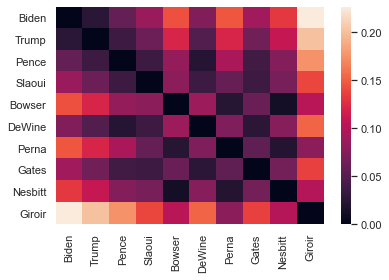

In [338]:
L = []
for p in corpora:
    l = []
    for q in corpora:
        l.append(Divergence(p, q, difference='KS'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns=speakerids, index=speakerids)
ax = sns.heatmap(div)
plt.show()

/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


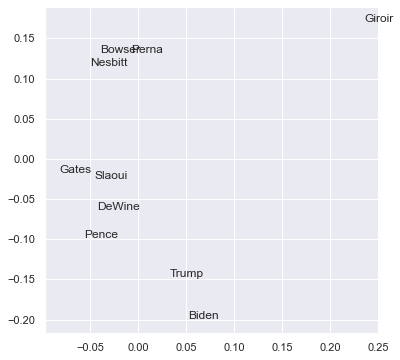

In [340]:
mds = sklearn.manifold.MDS()
pos = mds.fit(M).embedding_
x = pos[:, 0]
y = pos[:, 1]
fig, ax = plt.subplots(figsize = (6, 6))
plt.plot(x, y, ' ')
for i, txt in enumerate(speakerids):
    ax.annotate(txt, (x[i], y[i]))

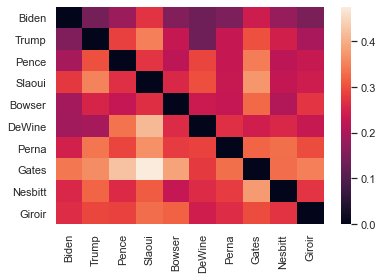

In [341]:
L = []
for p in corpora_s:
    l = []
    for q in corpora_s:
        l.append(Divergence(p,q, difference='KL'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = speakerids, index = speakerids)
ax = sns.heatmap(div)
plt.show()

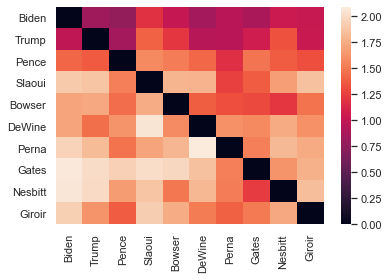

In [342]:
L = []
for p in corpora_nons:
    l = []
    for q in corpora_nons:
        l.append(Divergence(p,q, difference='KL'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = speakerids, index = speakerids)
ax = sns.heatmap(div)
plt.show()

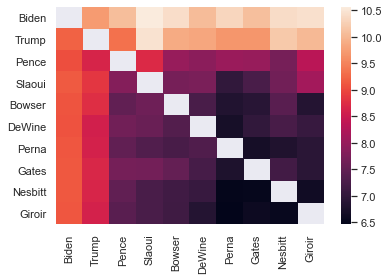

In [344]:
from matplotlib.colors import LogNorm
L = []
for p in corpora_nons:
    l = []
    for q in corpora_nons:
        l.append(Divergence(p,q, difference='Chi2'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = speakerids, index = speakerids)
ax = sns.heatmap(div.apply(np.log).replace([np.inf, -np.inf], np.nan))
plt.show()

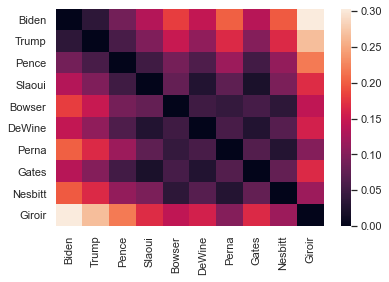

In [345]:
L = []
for p in corpora_nons:
    l = []
    for q in corpora_nons:
        l.append(Divergence(p,q, difference='KS'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = speakerids, index = speakerids)
ax = sns.heatmap(div)
plt.show()

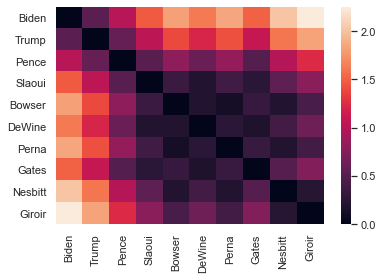

In [347]:
L = []
for p in corpora_nons:
    l = []
    for q in corpora_nons:
        l.append(Divergence(p,q, difference='Wasserstein'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = speakerids, index = speakerids)
ax = sns.heatmap(div)
plt.show()